In [108]:
# Load packages
import numpy as np
import gymnasium as gym
# import torch
import random
import matplotlib.pyplot as plt
from tqdm import trange
import itertools
from typing import List
from itertools import combinations, product

In [60]:
class Fourier_basis:

    def __init__(self, n_states, max_non_zero, p, type_coeffs, defined_coeffs):
        self.n_states = n_states #input size
        self.p = p
        self.max_non_zero = max_non_zero
        self.coeffs = self.define_coeffs(type_coeffs, defined_coeffs) 


    def define_coeffs(self, type_coeffs, defined_coeffs):
        
        if type_coeffs == "predefined":
            coeffs = defined_coeffs
        
        else:
            coeffs = np.array(np.zeros(self.n_states)) 

            for i in range(1, self.max_non_zero + 1):
                for indices in combinations(range(self.n_states), i):
                    for c in product(range(1, self.p + 1), repeat=i):
                        coef = np.zeros(self.n_states)
                        coef[list(indices)] = list(c)
                        coeffs = np.vstack((coeffs, coef))
        
        return coeffs

    def get_phi(self, state): ## to_basis
        return np.cos(np.pi*np.dot(self.coeffs, state))
    
    def scale_learning_rate(self, lr):
        norm = np.linalg.norm(self.coeffs, axis=1)
        norm[norm == 0.] = 1.  # When the norm is zero do not scale
        return lr / norm
    
    def get_num_basis(self):
        """Return the number of basis functions."""
        return self.coeffs.shape[0]



In [96]:
class SarsaLambda:
    def __init__(self, state_space, action_space, min_max_norm=False, alpha=0.0001, lamb=0.9, gamma=0.99, epsilon=0.05, fourier_order=2, max_non_zero_fourier=2, momentum = 0.4, initialization = "zeros", type_coeffs="nothing", defined_coeffs=None, reduction_factor= 1):
        # Hyperparameters
        self.alpha = alpha
        self.lamb = lamb
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Environment and state/action spaces
        self.env = gym.make('MountainCar-v0')
        self.state_space = state_space
        self.state_dim = self.state_space.shape[0]
        self.action_space = action_space
        self.action_dim = self.action_space.n

        # Fourier basis
        self.min_max_norm = min_max_norm
        self.p = fourier_order
        self.non_zero = max_non_zero_fourier
        self.basis = Fourier_basis(self.state_dim, self.non_zero, self.p, type_coeffs, defined_coeffs)
        self.scaled_lr = self.basis.scale_learning_rate(self.alpha)
        self.num_basis = self.basis.get_num_basis()

        # Weights and eligibility traces
        self.z = {a: np.zeros(self.num_basis) for a in range(self.action_dim)}

        if initialization == "zeros":
            self.w = {a: np.zeros(self.num_basis) for a in range(self.action_dim)}
        elif initialization == "random uniform":
            low, high = -1.0, 1.0  # Define the range for random initialization
            self.w = {a: np.random.uniform(low, high, self.num_basis) for a in range(self.action_dim)}
        elif initialization == "random gaussian":
            mean, std_dev = 0.0, 1.0
            return {a: np.random.normal(mean, std_dev, self.num_basis) for a in range(self.action_dim)}
     
     
        # Momentum-based SGD variables
        self.velocity = {a: np.zeros(self.num_basis) for a in range(self.action_dim)}
        self.momentum = momentum

        #lr updates
        self.last_threshold = float('-inf')
        self.reduction_factor = reduction_factor

    def get_q_value(self, w, action, state):
        """Compute Q-value for a given state and action."""
        return np.dot(w[action], self.basis.get_phi(state))
    

    def get_v_value(self, state):
        """Compute Q-value for a given state and action."""
        return np.max([np.dot(self.w[action], self.basis.get_phi(state)) for action in range(self.action_dim)])
    
    def discretize_state_space(self, n_points=100):
        """
        Discretize the state space into a grid for visualization.

        Args:
            n_points (int): Number of discretization points along each dimension.

        Returns:
            tuple: position_grid, velocity_grid representing the state space grid.
        """
        # Define a grid over the state space
        position_space = np.linspace(self.env.observation_space.low[0], self.env.observation_space.high[0], n_points)
        velocity_space = np.linspace(self.env.observation_space.low[1], self.env.observation_space.high[1], n_points)
        position_grid, velocity_grid = np.meshgrid(position_space, velocity_space)
        
        return position_grid, velocity_grid
    
    
    
    def get_v_function(self, n_points = 100):
        """
        Compute the value function over a discretized state space.

        Args:
            n_points (int): Number of points to discretize along each dimension.

        Returns:
            tuple: position_grid, velocity_grid, v_values representing the value function.
        """
        # Discretize the state space
        position_grid, velocity_grid = self.discretize_state_space(n_points)

        # Compute V-values for each state in the grid
        v_values = np.zeros_like(position_grid)
        for i in range(position_grid.shape[0]):
            for j in range(position_grid.shape[1]):
                state = np.array([position_grid[i, j], velocity_grid[i, j]])
                scaled_state = self.scale_state_variables(state)
                v_values[i, j] = self.get_v_value(scaled_state)

        return position_grid, velocity_grid, v_values




    def get_policy(self, n_points = 100):
        """Compute the optimal policy over the state space."""
    # Discretize the state space
        position_grid, velocity_grid = self.discretize_state_space(n_points)

        # Compute optimal action for each state in the grid
        optimal_policy = np.zeros_like(position_grid, dtype=int)
        for i in range(position_grid.shape[0]):
            for j in range(position_grid.shape[1]):
                state = np.array([position_grid[i, j], velocity_grid[i, j]])
                scaled_state = self.scale_state_variables(state)
                Q_values = [self.get_q_value(self.w, a, scaled_state) for a in range(self.action_dim)]
                optimal_policy[i, j] = np.argmax(Q_values)

        return position_grid, velocity_grid, optimal_policy
            

    def epsilon_greedy(self, state, test=False):
        """Choose action using epsilon-greedy policy."""
        if not test and random.random() < self.epsilon:
            return np.random.randint(0, self.action_dim)
        else:
            Q_s = [self.get_q_value(self.w, a, state) for a in range(self.action_dim)]
            return np.argmax(Q_s)

    def update_eligibility_trace(self, action, state):
        """Update eligibility traces."""

        phi_state = self.basis.get_phi(state)
        for a in range(self.action_dim):
            if a == action:
                self.z[a] = self.gamma * self.lamb * self.z[a] + phi_state
            else:
                self.z[a] = self.gamma * self.lamb * self.z[a]

    def update_weights_SGD(self, reward, q, next_q):
        """Update weights using SGD."""

        delta = reward + self.gamma * next_q - q  # Temporal difference error
        for a in range(self.action_dim):
            self.velocity[a] = self.momentum * self.velocity[a] + self.scaled_lr * delta * self.z[a]
            self.w[a] += self.velocity[a]

    def update_epsilon(self, decay=0.9999):
        """Decay epsilon."""
        self.epsilon *= decay

    # def update_learning_rate(self, decay_lr):
    #     """Decay learning rate."""
    #     self.alpha *= decay_lr
    #     self.scaled_lr = self.basis.scale_learning_rate(self.alpha)

    def update_learning_rate(self, avg_reward):
        """
        Reduce learning rate based on average reward thresholds.
        Args:
            avg_reward (float): The average reward over recent episodes.
            reduction_factor (float): Factor by which to reduce the learning rate.
        """
        thresholds = [-140, -135, -130, -125, -120, -115, -110, -105, -100, -95, -90]  # Define thresholds for learning rate reduction

        for threshold in thresholds:
            if avg_reward > threshold > self.last_threshold and self.alpha > 1e-6:  # Avoid reducing alpha below a very small value
                self.alpha *= self.reduction_factor
                self.scaled_lr = self.basis.scale_learning_rate(self.alpha)
                self.last_threshold = threshold
                #print(f"Baixo de {threshold}")
                break  # Apply one reduction at a time to avoid excessive lowering


    def reset_z_v(self):
        """Reset eligibility traces and velocity vectors"""
        for a in range(self.action_dim):
            self.z[a].fill(0.0)
            self.velocity[a].fill(0.0)

    def scale_state_variables(self, s ):
        """Rescale state variables to [0, 1]^n."""
        low=self.env.observation_space.low
        high=self.env.observation_space.high

        return (s - low) / (high - low)

    def sarsa_learning_step(self, state, action, reward, next_state, next_action, done):
        """Perform one step of SARSA(λ)."""
        
        q = self.get_q_value(self.w, action, state)

        if not done:
            next_q = self.get_q_value(self.w, next_action, next_state)
        else:
            next_q = 0.0

        self.update_eligibility_trace(action, state)
        self.update_weights_SGD(reward, q, next_q)
        self.update_epsilon()
        #self.update_learning_rate(self.decay_lr)

        if done:
            self.reset_z_v()


In [97]:
class Trainer:
    def __init__(self, environment: gym.Env,
                 agent: SarsaLambda,
                 epsilon: float = 0.3,
                 number_episodes: int = 500,
                 episode_reward_trigger: float = -135,
                 early_stopping=False
                 ):
        
        ## SET PARAMETERS
        self.early_stopping = early_stopping
        self.episode_reward_trigger = episode_reward_trigger
        self.number_episodes = number_episodes
        self.env = environment
        self.agent = agent
        self.epsilon = epsilon
        self.reduction_factor = reduction_factor
    

        ## SET VARIABLES
        self.episode_reward_list = []

    # Functions used during training
    def running_average(self, x, N):
        ''' Function used to compute the running mean
            of the last N elements of a vector x
        '''
        if len(x) >= N:
            y = np.copy(x)
            y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
        else:
            y = np.zeros_like(x)
        return y

    def decay_lr(self):
    # Compute average reward over last 30 episodes
        if len(self.episode_reward_list) >= 30:
            avg_reward = np.mean(self.episode_reward_list[-30:])
        else:
            avg_reward = np.mean(self.episode_reward_list)

        # Update learning rate and epsilon
        self.agent.update_learning_rate(avg_reward)

    def train(self):
        #np.random.seed(10)
        ### RESET ENVIRONMENT ###
        self.env.reset() ########

        time = 0

        for e in trange(self.number_episodes):
            done = False
            terminated = False
            state = self.agent.scale_state_variables(self.env.reset()[0])
            total_episode_reward = 0.

            while not (done or terminated):
                ### TAKE ACTION ###
                action = self.agent.epsilon_greedy(state)

                ### USE ACTION ###
                next_state, reward, done, terminated, _ = self.env.step(action)
                next_state = self.agent.scale_state_variables(next_state)

                ### COMPUTE NEXT ACTION
                next_action = self.agent.epsilon_greedy(next_state)

                ### USE SARSA
                self.agent.sarsa_learning_step(state, action, reward, next_state, next_action, done)

                ## UPDATE DATA
                total_episode_reward += reward
                state = next_state


            self.episode_reward_list.append(total_episode_reward)

            self.decay_lr()

            #if e>=30 and self.running_average(self.episode_reward_list, 30)[-1] > self.episode_reward_trigger and self.early_stopping:
            #    break

   
    def test(self, N=50, verbose=False):

        N_EPISODES = N  # Number of episodes to run for trainings
        CONFIDENCE_PASS = -135
        print('Checking solution...')
        EPISODES = trange(N_EPISODES, desc='Episode: ', leave=True)
        episode_reward_list = []
        for i in EPISODES:
            # EPISODES.set_description("Episode {}".format(i))
            # Reset enviroment data
            done = False
            truncated = False
            state = self.agent.scale_state_variables(self.env.reset()[0])
            total_episode_reward = 0.

            action = self.agent.epsilon_greedy(state, test=True)

            while not (done or truncated):
                # Get next state and reward.  The done variable
                # will be True if you reached the goal position,
                # False otherwise
                next_state, reward, done, truncated, *_ = self.env.step(action)
                next_state = self.agent.scale_state_variables(next_state)
                next_action = self.agent.epsilon_greedy(state, test=True)

                # Update episode reward
                total_episode_reward += reward

                # Update state for next iteration
                state = next_state
                action = next_action

            # Append episode reward
            episode_reward_list.append(total_episode_reward)

            # Close environment
            self.env.close()

        avg_reward = np.mean(episode_reward_list)
        confidence = np.std(episode_reward_list) * 1.96 / np.sqrt(N_EPISODES)

        if verbose:
            print('Policy achieves an average total reward of {:.1f} +/- {:.1f} with confidence 95%.'.format(
                avg_reward,
                confidence))

        if avg_reward - confidence >= CONFIDENCE_PASS:
            if verbose:
                print('Your policy passed the test!')
            return True, avg_reward, confidence
        else:
            if verbose:
                print(
                    'Your policy did not pass the test! The average reward of your policy needs to be greater than {} with 95% confidence'.format(
                        CONFIDENCE_PASS))
            return False, avg_reward, confidence

            

In [38]:
### AIXO ES DE CHATGPT I NO HO HE PROVAT (quan li he passat pregunta e.1)

In [ ]:
def experiment_on_alpha_or_lambda(env, param_name="alpha", param_values=None, fixed_params=None, n_episodes=500, test_episodes=50):
    """
    Evaluate the policy performance as a function of a parameter (alpha or lambda).
    
    Args:
        env (gym.Env): Environment.
        param_name (str): Parameter to vary ('alpha' or 'lamb').
        param_values (list): Values to test for the parameter.
        fixed_params (dict): Fixed hyperparameters for the agent.
        n_episodes (int): Number of training episodes.
        test_episodes (int): Number of episodes for testing.
        
    Returns:
        list: List of average rewards and confidence intervals for each parameter value.
    """
    assert param_name in ["alpha", "lamb"], "Invalid parameter name!"
    
    results = []
    for value in param_values:
        print(f"Testing {param_name} = {value:.4f}")
        
        # Update the variable parameter
        params = fixed_params.copy()
        params[param_name] = value

        # Initialize agent and trainer
        agent = SarsaLambda(
            state_space=env.observation_space,
            action_space=env.action_space,
            alpha=params["alpha"],
            lamb=params["lamb"],
            gamma=params["gamma"],
            epsilon=params["epsilon"],
            fourier_order=params["fourier_order"],
            max_non_zero_fourier=params["max_non_zero_fourier"]
        )
        
        trainer = Trainer(environment=env, agent=agent, number_episodes=n_episodes)
        
        # Train and test
        trainer.train()
        _, avg_reward, confidence = trainer.test(N=test_episodes)
        
        results.append((value, avg_reward, confidence))
    
    return results


def plot_results(results, param_name):
    """Plot average rewards as a function of a parameter."""
    param_values = [r[0] for r in results]
    avg_rewards = [r[1] for r in results]
    conf_intervals = [r[2] for r in results]
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(param_values, avg_rewards, yerr=conf_intervals, fmt='-o', capsize=5, label="Average Reward")
    plt.title(f"Effect of {param_name} on Policy Performance")
    plt.xlabel(param_name)
    plt.ylabel("Average Total Reward")
    plt.grid(True)
    plt.legend()
    plt.show()

# Plot alpha results
plot_results(alpha_results, param_name="alpha")

# Plot lambda results
plot_results(lambda_results, param_name="lambda")


# Fixed parameters
fixed_params = {
    "alpha": 0.001,
    "lamb": 0.9,
    "gamma": 0.99,
    "epsilon": 0.3,
    "fourier_order": 2,
    "max_non_zero_fourier": 2,
}

# Test alpha values
alpha_values = [0.0001, 0.001, 0.01, 0.1]
env = gym.make('MountainCar-v0')
alpha_results = experiment_on_alpha_or_lambda(env, param_name="alpha", param_values=alpha_values, fixed_params=fixed_params)

# Test lambda values
lambda_values = [0.0, 0.3, 0.6, 0.9, 1.0]
lambda_results = experiment_on_alpha_or_lambda(env, param_name="lamb", param_values=lambda_values, fixed_params=fixed_params)

env.close()





In [ ]:
#### pregunta d.2 i d.3

Starting training...


100%|██████████| 500/500 [00:08<00:00, 56.77it/s]


Training completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 137.82it/s]


Policy achieves an average total reward of -125.5 +/- 4.8 with confidence 95%.
Your policy passed the test!
Testing completed!


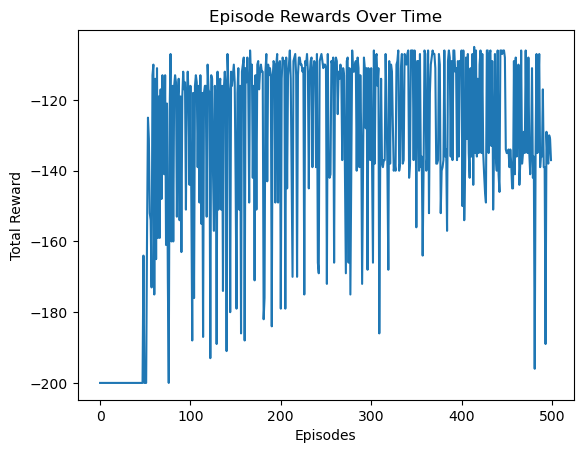

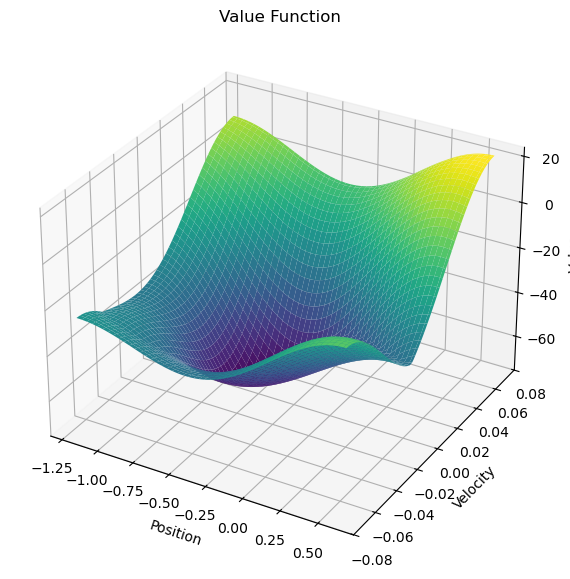

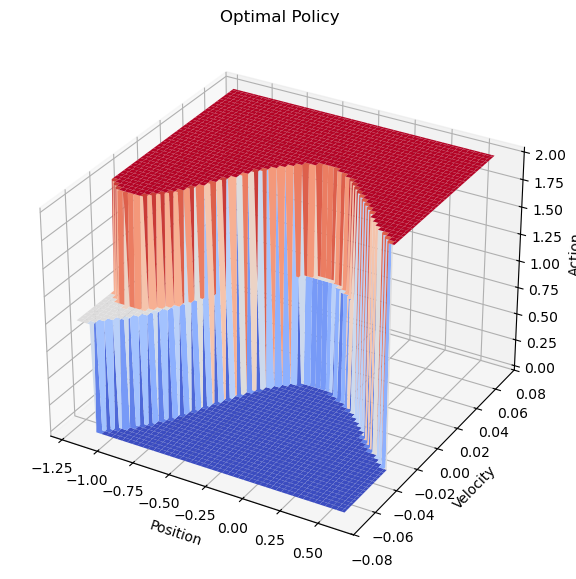

In [75]:
def plot_policy(position_grid, velocity_grid, optimal_policy):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(position_grid, velocity_grid, optimal_policy, cmap='coolwarm')
    ax.set_title("Optimal Policy")
    ax.set_xlabel("Position")
    ax.set_ylabel("Velocity")
    ax.set_zlabel("Action")
    plt.show()


def plot_v_function(position_grid, velocity_grid, v_values):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(position_grid, velocity_grid, value_function, cmap='viridis')
    ax.set_title("Value Function")
    ax.set_xlabel("Position")
    ax.set_ylabel("Velocity")
    ax.set_zlabel("Value")
    plt.show()



if __name__ == "__main__":
    # Initialize environment
    env = gym.make('MountainCar-v0')
    
    # Set hyperparameters for SARSA(λ)
    state_space = env.observation_space
    action_space = env.action_space
    alpha = 0.001  # Learning rate
    lamb = 0.6  # λ value for eligibility traces
    gamma = 0.99  # Discount factor
    epsilon = 0.1  # Exploration probability
    fourier_order = 2  # Fourier order
    max_non_zero_fourier = 2  # Max non-zero Fourier coefficients

    
    
    # Initialize SARSA(λ) agent
    agent = SarsaLambda(
        state_space=state_space,
        action_space=action_space,
        alpha=alpha,
        lamb=lamb,
        gamma=gamma,
        epsilon=epsilon,
        fourier_order=fourier_order,
        max_non_zero_fourier=max_non_zero_fourier
    )
    
    # Initialize trainer
    trainer = Trainer(
        environment=env,
        agent=agent,
        epsilon=epsilon,
        number_episodes=500,  # Number of episodes to train
        episode_reward_trigger=-150,  # Reward threshold for early stopping
        early_stopping=True  # Enable early stopping
    )
    
    # Train the agent
    print("Starting training...")
    trainer.train()
    print("Training completed!")
    trainer.test(N=50, verbose=True)
    print("Testing completed!")
    
    # Plot training results
    plt.plot(trainer.episode_reward_list)
    plt.title("Episode Rewards Over Time")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.show()


    # Plot the value function
    position_grid, velocity_grid, v_values = agent.get_v_function()
    plot_v_function(position_grid, velocity_grid, v_values)

    # Plot the optimal policy 
    position_grid, velocity_grid, optimal_policy = agent.get_policy()
    plot_policy(position_grid, velocity_grid, optimal_policy)

    env.close()

In [ ]:
# hyperparameter optimization en general

In [71]:
from itertools import product
import numpy as np

def grid_search_hyperparameters(env, hyperparameters, n_trials=3, n_episodes=500, test_episodes=50):
    """
    Perform a grid search over the given hyperparameters.

    Args:
        env (gym.Env): The environment.
        hyperparameters (dict): Dictionary where keys are parameter names and values are lists of values to try.
        n_trials (int): Number of trials (train-test cycles) for each hyperparameter combination.
        n_episodes (int): Number of training episodes per trial.
        test_episodes (int): Number of test episodes per trial.
        
    Returns:
        results (list): List of dictionaries, each containing a combination of hyperparameters and its performance metrics.
    """
    # Generate all combinations of hyperparameters
    param_names = list(hyperparameters.keys())
    param_combinations = list(product(*hyperparameters.values()))
    
    results = []
    
    for params in param_combinations:
        # Create a dictionary for the current combination of parameters
        param_dict = dict(zip(param_names, params))
        print(f"Testing combination: {param_dict}")
        
        all_rewards = []
        
        for trial in range(n_trials):
            # Initialize the agent with the current hyperparameters
            agent = SarsaLambda(
                state_space=env.observation_space,
                action_space=env.action_space,
                alpha=param_dict.get("alpha", 0.001),
                lamb=param_dict.get("lamb", 0.9),
                gamma=param_dict.get("gamma", 0.99),
                epsilon=param_dict.get("epsilon", 0.3),
                fourier_order=param_dict.get("fourier_order", 2),
                max_non_zero_fourier=param_dict.get("max_non_zero_fourier", 2)
            )
            
            # Train the agent
            trainer = Trainer(environment=env, agent=agent, number_episodes=n_episodes)
            trainer.train()
            
            # Test the agent and record the average reward
            _, avg_reward, _ = trainer.test(N=test_episodes)
            all_rewards.append(avg_reward)
        
        # Compute statistics across trials
        avg_reward = np.mean(all_rewards)
        std_reward = np.std(all_rewards)
        
        # Store the results
        results.append({
            **param_dict,
            "avg_reward": avg_reward,
            "std_reward": std_reward
        })
        
    return results


In [72]:
# Define the environment
env = gym.make('MountainCar-v0')

# Define hyperparameters and their values to test
hyperparameter_grid = {
    "alpha": [0.0001, 0.001, 0.01],
    "lamb": [0.6, 0.9],
    "epsilon": [0.1, 0.3]
}

# Perform grid search
grid_results = grid_search_hyperparameters(env, hyperparameter_grid, n_trials=3, n_episodes=500, test_episodes=50)

# Print results
for res in grid_results:
    print(f"Params: {res}, Avg Reward: {res['avg_reward']:.2f}, Std Dev: {res['std_reward']:.2f}")


Testing combination: {'alpha': 0.0001, 'lamb': 0.6, 'epsilon': 0.1}


100%|██████████| 500/500 [00:12<00:00, 41.28it/s]


Checking solution...


100%|██████████| 500/500 [00:11<00:00, 41.71it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 41.41it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 136.31it/s]


Testing combination: {'alpha': 0.0001, 'lamb': 0.6, 'epsilon': 0.3}


100%|██████████| 500/500 [00:11<00:00, 42.06it/s]


Checking solution...


100%|██████████| 500/500 [00:11<00:00, 42.29it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 40.69it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 108.22it/s]


Testing combination: {'alpha': 0.0001, 'lamb': 0.9, 'epsilon': 0.1}


100%|██████████| 500/500 [00:10<00:00, 47.94it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 49.25it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 49.03it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 159.09it/s]


Testing combination: {'alpha': 0.0001, 'lamb': 0.9, 'epsilon': 0.3}


100%|██████████| 500/500 [00:10<00:00, 49.16it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 48.57it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 49.29it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 123.97it/s]


Testing combination: {'alpha': 0.001, 'lamb': 0.6, 'epsilon': 0.1}


100%|██████████| 500/500 [00:08<00:00, 60.38it/s]


Checking solution...


100%|██████████| 500/500 [00:08<00:00, 59.93it/s]


Checking solution...


100%|██████████| 500/500 [00:08<00:00, 61.11it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 164.04it/s]


Testing combination: {'alpha': 0.001, 'lamb': 0.6, 'epsilon': 0.3}


100%|██████████| 500/500 [00:08<00:00, 60.36it/s]


Checking solution...


100%|██████████| 500/500 [00:08<00:00, 60.64it/s]


Checking solution...


100%|██████████| 500/500 [00:08<00:00, 60.12it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 148.12it/s]


Testing combination: {'alpha': 0.001, 'lamb': 0.9, 'epsilon': 0.1}


100%|██████████| 500/500 [00:08<00:00, 58.45it/s]


Checking solution...


100%|██████████| 500/500 [00:08<00:00, 59.62it/s]


Checking solution...


100%|██████████| 500/500 [00:08<00:00, 58.72it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 146.17it/s]


Testing combination: {'alpha': 0.001, 'lamb': 0.9, 'epsilon': 0.3}


100%|██████████| 500/500 [00:08<00:00, 58.51it/s]


Checking solution...


100%|██████████| 500/500 [00:08<00:00, 58.14it/s]


Checking solution...


100%|██████████| 500/500 [00:09<00:00, 54.18it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 141.28it/s]


Testing combination: {'alpha': 0.01, 'lamb': 0.6, 'epsilon': 0.1}


100%|██████████| 500/500 [00:10<00:00, 46.72it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 47.04it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 46.70it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 102.24it/s]


Testing combination: {'alpha': 0.01, 'lamb': 0.6, 'epsilon': 0.3}


100%|██████████| 500/500 [00:10<00:00, 45.52it/s]


Checking solution...


100%|██████████| 500/500 [00:11<00:00, 45.14it/s]


Checking solution...


100%|██████████| 500/500 [00:11<00:00, 44.72it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 96.70it/s]


Testing combination: {'alpha': 0.01, 'lamb': 0.9, 'epsilon': 0.1}


100%|██████████| 500/500 [00:09<00:00, 53.18it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 46.06it/s]


Checking solution...


100%|██████████| 500/500 [00:11<00:00, 42.78it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 102.54it/s]


Testing combination: {'alpha': 0.01, 'lamb': 0.9, 'epsilon': 0.3}


100%|██████████| 500/500 [00:11<00:00, 42.20it/s]


Checking solution...


100%|██████████| 500/500 [00:11<00:00, 43.25it/s]


Checking solution...


100%|██████████| 500/500 [00:11<00:00, 44.55it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 117.07it/s]

Params: {'alpha': 0.0001, 'lamb': 0.6, 'epsilon': 0.1, 'avg_reward': -164.46666666666667, 'std_reward': 24.054013294158526}, Avg Reward: -164.47, Std Dev: 24.05
Params: {'alpha': 0.0001, 'lamb': 0.6, 'epsilon': 0.3, 'avg_reward': -166.47333333333333, 'std_reward': 12.723525018205018}, Avg Reward: -166.47, Std Dev: 12.72
Params: {'alpha': 0.0001, 'lamb': 0.9, 'epsilon': 0.1, 'avg_reward': -144.0533333333333, 'std_reward': 22.415532313306525}, Avg Reward: -144.05, Std Dev: 22.42
Params: {'alpha': 0.0001, 'lamb': 0.9, 'epsilon': 0.3, 'avg_reward': -145.66666666666666, 'std_reward': 19.384401518288417}, Avg Reward: -145.67, Std Dev: 19.38
Params: {'alpha': 0.001, 'lamb': 0.6, 'epsilon': 0.1, 'avg_reward': -126.21333333333332, 'std_reward': 1.8054977768533063}, Avg Reward: -126.21, Std Dev: 1.81
Params: {'alpha': 0.001, 'lamb': 0.6, 'epsilon': 0.3, 'avg_reward': -128.69333333333333, 'std_reward': 0.23683092891108157}, Avg Reward: -128.69, Std Dev: 0.24
Params: {'alpha': 0.001, 'lamb': 0.9, 

In [ ]:
### INTENT GRID SEARCH (INCLOENT HYPERPARAMETRES I BASIS FUNCTION)

In [ ]:
import itertools

def hyperparameter_grid_search(agent_class, env, param_grid, num_episodes=50, test_episodes=50):
    """
    Perform grid search over hyperparameters.
    
    agent_class: Class of the agent (e.g., SarsaLambda)
    env: The environment in which the agent will train.
    param_grid: Dictionary where each key is a hyperparameter and the value is a list of possible values to test.
    num_episodes: Number of episodes to train the agent per hyperparameter setting.
    test_episodes: Number of episodes to test the agent per hyperparameter setting.
    """
    best_avg_reward = -np.inf
    best_params = None
    results = []
    
    # Get all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, combination)) for combination in itertools.product(*values)]
    
    for params in param_combinations:
        print(f"Testing hyperparameters: {params}")
        
        # Initialize agent with current set of parameters
        basis_type = params.get("basis_type", "generated")  # If not present, use 'generated' basis
        
        if basis_type == "predefined":
            predefined_coeffs = params.get("predefined_coeffs", None)  # Ensure predefined coefficients are passed
            agent = agent_class(
                state_space=env.observation_space,
                action_space=env.action_space,
                init_strategy=params['init_strategy'],
                basis_type="predefined", 
                defined_coeffs=predefined_coeffs,
                alpha=params['alpha'],
                lamb=params['lambda'],
                gamma=params['gamma'],
                epsilon=params['epsilon']
            )
        else:
            agent = agent_class(
                state_space=env.observation_space,
                action_space=env.action_space,
                init_strategy=params['init_strategy'],
                basis_type="generated",  # Generate basis if not predefined
                defined_coeffs=None,  # Not needed
                alpha=params['alpha'],
                lamb=params['lambda'],
                gamma=params['gamma'],
                epsilon=params['epsilon']
            )
        
        # Training the agent for the given number of episodes
        trainer = Trainer(environment=env, agent=agent, epsilon=params['epsilon'], number_episodes=num_episodes)
        trainer.train()
        
        # Testing the agent on the test episodes
        success, avg_reward, confidence = trainer.test(N=test_episodes, verbose=False)
        
        # Store results
        results.append({
            "params": params,
            "avg_reward": avg_reward,
            "confidence": confidence
        })
        
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            best_params = params

    # Output the results
    print("Best Hyperparameters:", best_params)
    print("Best Average Reward:", best_avg_reward)
    
    return results, best_params


In [ ]:
predefined_coeff_matrix_1 = np.array([
                [1, 0],
                [0, 1]
                ])

predefined_coeff_matrix_2 = np.array([
                [0, 0],
                [0, 1],
                [1, 0],
                [1, 1],
                ])

predefined_coeff_matrix_3 = np.array([
                [0, 1],
                [0, 2],
                [1, 0],
                [1, 1],
                [1, 2],
                [2, 0],
                [2, 1],
                [2, 2]
                ])

predefined_coeff_matrix_4 = np.array([
                [0, 0],
                [0, 1],
                [0, 2],
                [1, 0],
                [1, 1],
                [1, 2],
                [2, 0],
                [2, 1],
                [2, 2],
                ]) ##this is the same we get if we use default basis (max_non_zero = 2)

[[0. 0.]
 [1. 0.]
 [2. 0.]
 [0. 1.]
 [0. 2.]
 [1. 1.]
 [1. 2.]
 [2. 1.]
 [2. 2.]]


In [ ]:
param_grid = {
    'alpha': [0.01, 0.001, 0.0001],
    'lambda': [0.5, 0.9, 1.0],
    'gamma': [0.9, 0.99, 1.0],
    'epsilon': [0.1, 0.3, 0.5],
    'init_strategy': ['zero', 'random_uniform', 'random_gaussian'],
    'basis_type': ['predefined'],
    'predefined_coeffs': [predefined_coeff_matrix_1, predefined_coeff_matrix_2, predefined_coeff_matrix_3, predefined_coeff_matrix_4]  # If using predefined, provide the coefficient matrix
}


In [7]:
### b) design of fourier basis

In [39]:
predefined_coeff_matrix_1 = np.array([
                [1, 0],
                [0, 1]
                ])

predefined_coeff_matrix_2 = np.array([
                [0, 0],
                [0, 1],
                [1, 0],
                [1, 1],
                ])

predefined_coeff_matrix_2_1 = np.array([
                [0, 1],
                [1, 0],
                [1, 1],
                ])

predefined_coeff_matrix_3 = np.array([
                [0, 1],
                [0, 2],
                [1, 0],
                [1, 1],
                [1, 2],
                [2, 0],
                [2, 1],
                [2, 2]
                ])

predefined_coeff_matrix_4 = np.array([
                [0, 0],
                [0, 1],
                [0, 2],
                [1, 0],
                [1, 1],
                [1, 2],
                [2, 0],
                [2, 1],
                [2, 2],
                ]) ##this is the same we get if we use default basis (max_non_zero = 2)

In [15]:
# n_states= 2
# max_non_zero_fourier = 2
# p=2

# coeffs = np.array(np.zeros(n_states)) 

# for i in range(1, max_non_zero_fourier+1):
#     for indices in combinations(range(n_states), i):
#         for c in product(range(1, p + 1), repeat=i):
#             coef = np.zeros(n_states)
#             coef[list(indices)] = list(c)
#             coeffs = np.vstack((coeffs, coef))

# print(coeffs)


Starting training...


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:12<00:00, 38.75it/s]


Training completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 92.21it/s]


Policy achieves an average total reward of -198.5 +/- 0.5 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing completed!


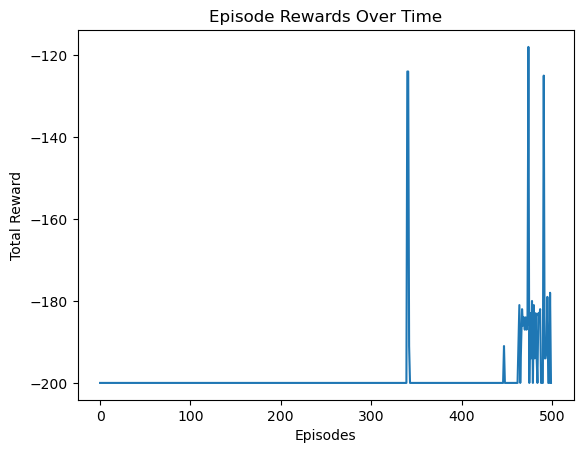

Starting training...


100%|██████████| 500/500 [00:10<00:00, 46.63it/s]


Training completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 139.00it/s]


Policy achieves an average total reward of -141.9 +/- 8.9 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing completed!


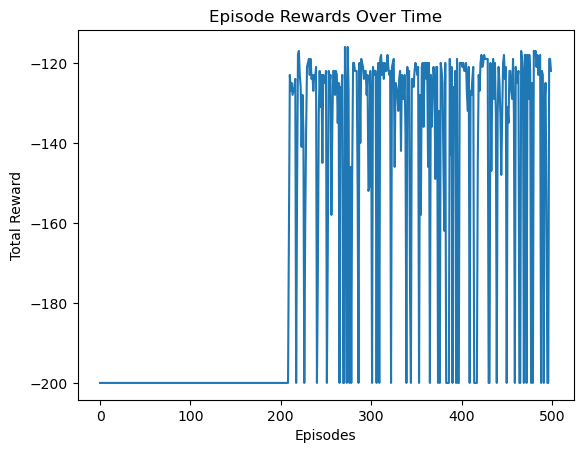

Starting training...


100%|██████████| 500/500 [00:09<00:00, 53.17it/s]


Training completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 158.83it/s]


Policy achieves an average total reward of -125.6 +/- 6.8 with confidence 95%.
Your policy passed the test!
Testing completed!


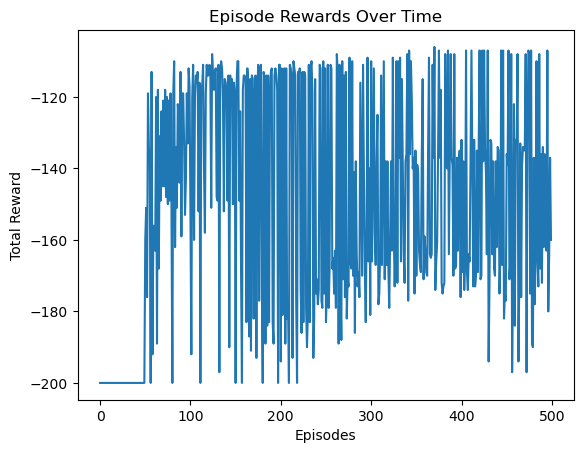

Starting training...


100%|██████████| 500/500 [00:08<00:00, 57.93it/s]


Training completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 151.48it/s]


Policy achieves an average total reward of -129.6 +/- 5.1 with confidence 95%.
Your policy passed the test!
Testing completed!


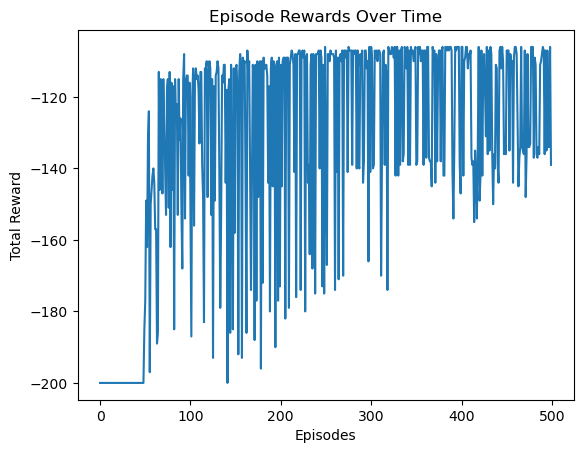

In [17]:
if __name__ == "__main__":

    predefined_coeffs = [predefined_coeff_matrix_1, predefined_coeff_matrix_2, predefined_coeff_matrix_3, predefined_coeff_matrix_4]  # If using predefined, provide the coefficient matrix


    for coeficients in predefined_coeffs:
        # Initialize environment
        env = gym.make('MountainCar-v0')
        
        # Set hyperparameters for SARSA(λ)
        state_space = env.observation_space
        action_space = env.action_space
        alpha = 0.001  # Learning rate
        lamb = 0.6  # λ value for eligibility traces
        gamma = 1 # Discount factor
        epsilon = 0.1  # Exploration probability
        fourier_order = 2  # Fourier order
        max_non_zero_fourier = 2  # Max non-zero Fourier coefficients
    
        # Initialize SARSA(λ) agent
        agent = SarsaLambda(
            state_space=state_space,
            action_space=action_space,
            alpha=alpha,
            lamb=lamb,
            gamma=gamma,
            epsilon=epsilon,
            fourier_order=fourier_order,
            max_non_zero_fourier=max_non_zero_fourier,
            type_coeffs="predefined",
            defined_coeffs = coeficients
        )
        
        # Initialize trainer
        trainer = Trainer(
            environment=env,
            agent=agent,
            epsilon=epsilon,
            number_episodes=500,  # Number of episodes to train
            episode_reward_trigger=-150,  # Reward threshold for early stopping
            early_stopping=True  # Enable early stopping
        )
        
        # Train the agent
        print("Starting training...")
        trainer.train()
        print("Training completed!")
        trainer.test(N=50, verbose=True)
        print("Testing completed!")
        
        # Plot training results
        plt.plot(trainer.episode_reward_list)
        plt.title("Episode Rewards Over Time")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.show()

    env.close()

In [40]:
def plot_smoothed_rewards(rewards, window_size=20):
    """
    Plots smoothed rewards using a moving average.

    Parameters:
        rewards (list or np.array): The list of rewards for each episode.
        window_size (int): The size of the sliding window for averaging. Default is 20.
    """
    # Compute the moving average
    smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    
    # Plot the results
    plt.plot(smoothed_rewards)
    plt.title(f"Smoothed Episode Rewards (Window Size: {window_size})")
    plt.xlabel("Episodes")
    plt.ylabel("Smoothed Total Reward")
    plt.show()

In [41]:
def plot_all_smoothed_rewards(reward_vectors, window_size=20, labels=None):
    """
    Plots smoothed rewards for multiple attempts.

    Parameters:
        reward_vectors (list of lists): A list where each element is a list of rewards for one attempt.
        window_size (int): The size of the sliding window for averaging. Default is 20.
        labels (list of str): Labels for each attempt. Default is None.
    """
    plt.figure(figsize=(10, 6))
    for i, rewards in enumerate(reward_vectors):
        # Compute the moving average
        smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode="valid")
        
        # Use the provided label or default to "Attempt i+1"
        label = labels[i] if labels and i < len(labels) else f"Attempt {i + 1}"
        
        plt.plot(smoothed_rewards, label=label)
    
    plt.title("Smoothed Episode Rewards Across Attempts")
    plt.xlabel("Episodes (smoothed)")
    plt.ylabel("Smoothed Total Reward")
    plt.legend()
    plt.show()

Starting training...


100%|██████████| 500/500 [00:12<00:00, 38.88it/s]


Training completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 103.26it/s]


Policy achieves an average total reward of -199.0 +/- 0.6 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing completed!


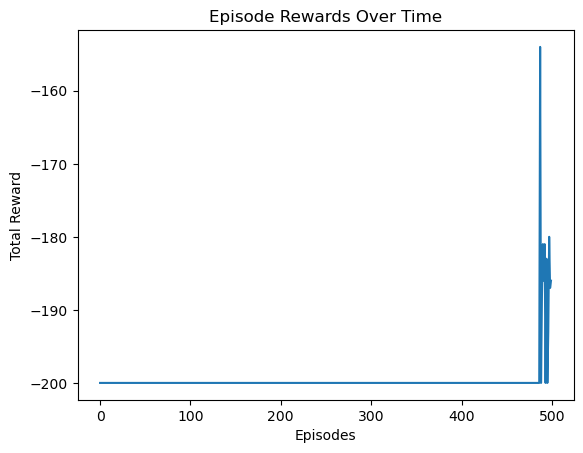

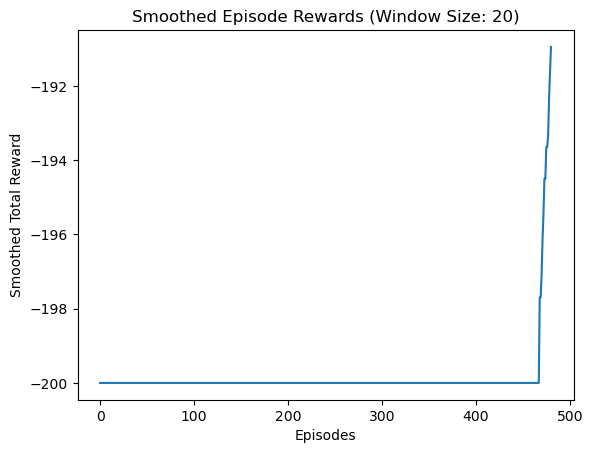

Starting training...


100%|██████████| 500/500 [00:11<00:00, 45.33it/s]


Training completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 145.79it/s]


Policy achieves an average total reward of -139.3 +/- 9.5 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing completed!


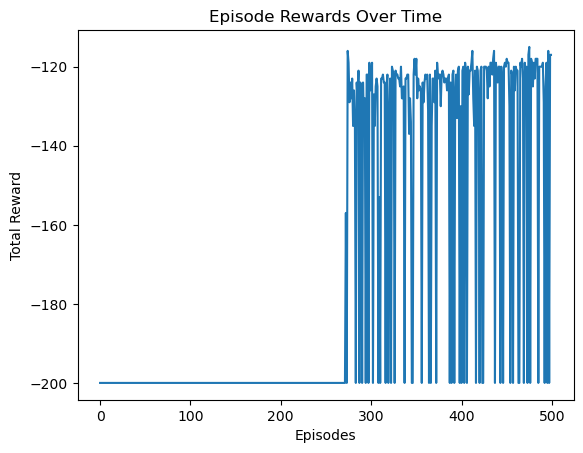

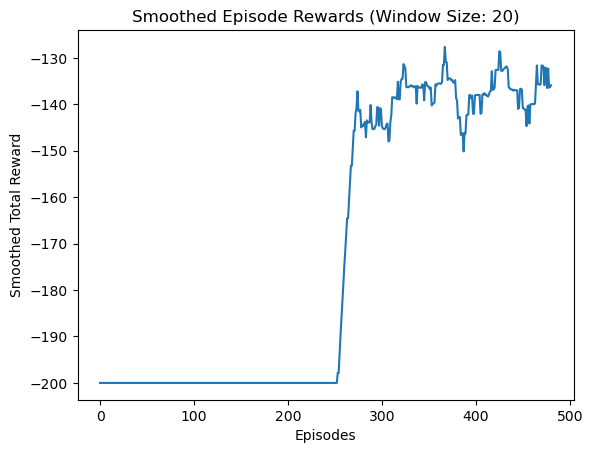

Starting training...


100%|██████████| 500/500 [00:10<00:00, 49.18it/s]


Training completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 146.52it/s]


Policy achieves an average total reward of -122.9 +/- 6.4 with confidence 95%.
Your policy passed the test!
Testing completed!


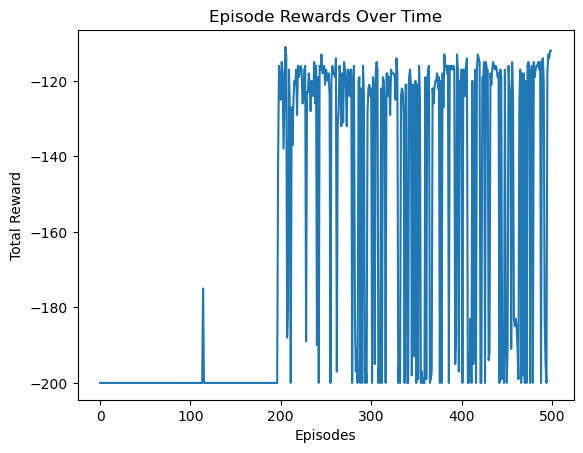

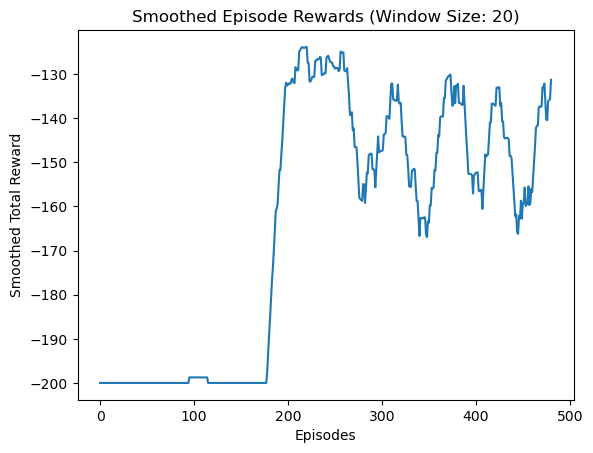

Starting training...


100%|██████████| 500/500 [00:09<00:00, 50.48it/s]


Training completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 135.55it/s]


Policy achieves an average total reward of -135.8 +/- 6.6 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing completed!


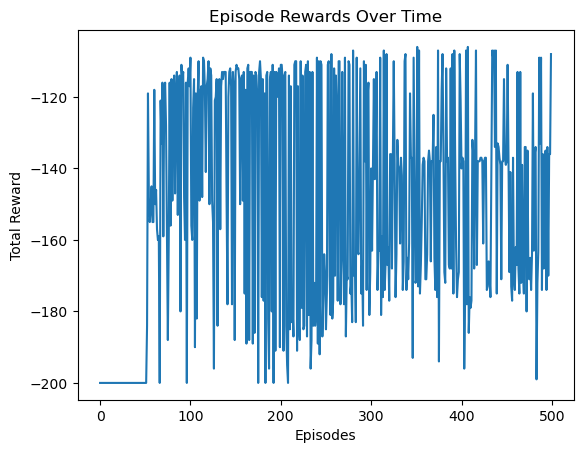

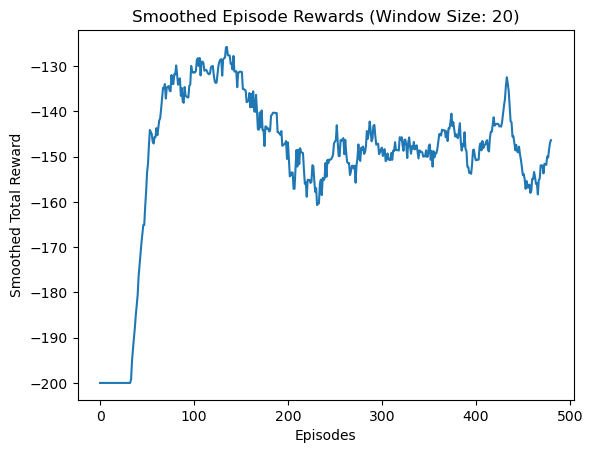

Starting training...


100%|██████████| 500/500 [00:09<00:00, 55.25it/s]


Training completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 131.48it/s]


Policy achieves an average total reward of -132.3 +/- 4.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing completed!


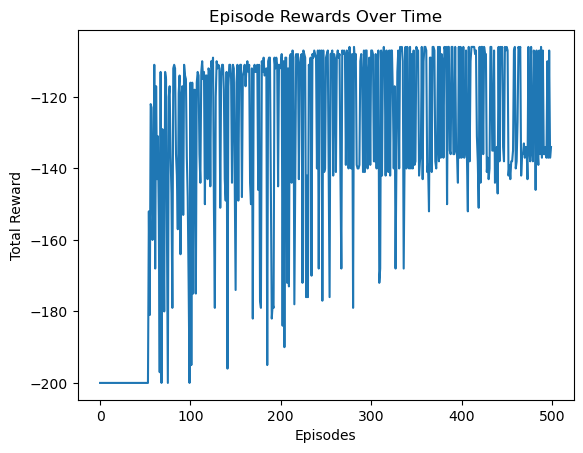

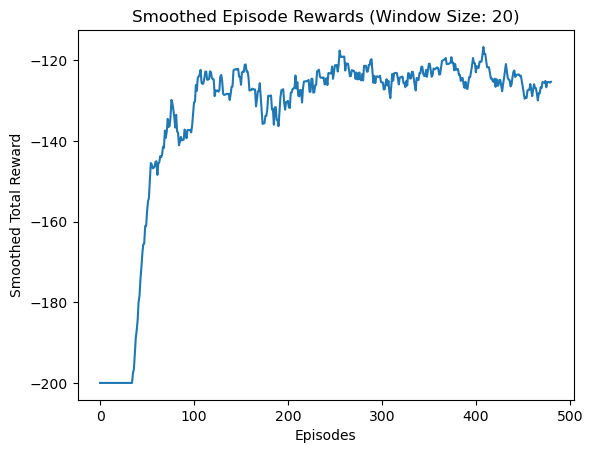

In [21]:
if __name__ == "__main__":

    predefined_coeffs = [predefined_coeff_matrix_1, predefined_coeff_matrix_2, predefined_coeff_matrix_2_1, predefined_coeff_matrix_3, predefined_coeff_matrix_4]  # If using predefined, provide the coefficient matrix

    total_rewards = []

    for coeficients in predefined_coeffs:
        # Initialize environment
        env = gym.make('MountainCar-v0')
        
        # Set hyperparameters for SARSA(λ)
        state_space = env.observation_space
        action_space = env.action_space
        alpha = 0.001  # Learning rate
        lamb = 0.6  # λ value for eligibility traces
        gamma = 1 # Discount factor
        epsilon = 0.1  # Exploration probability
        fourier_order = 2  # Fourier order
        max_non_zero_fourier = 2  # Max non-zero Fourier coefficients
    
        # Initialize SARSA(λ) agent
        agent = SarsaLambda(
            state_space=state_space,
            action_space=action_space,
            alpha=alpha,
            lamb=lamb,
            gamma=gamma,
            epsilon=epsilon,
            fourier_order=fourier_order,
            max_non_zero_fourier=max_non_zero_fourier,
            type_coeffs="predefined",
            defined_coeffs = coeficients
        )
        
        # Initialize trainer
        trainer = Trainer(
            environment=env,
            agent=agent,
            epsilon=epsilon,
            number_episodes=500,  # Number of episodes to train
            episode_reward_trigger=-150,  # Reward threshold for early stopping
            early_stopping=True  # Enable early stopping
        )
        
        # Train the agent
        print("Starting training...")
        trainer.train()
        print("Training completed!")
        trainer.test(N=50, verbose=True)
        print("Testing completed!")
        
        # Plot training results
        plt.plot(trainer.episode_reward_list)
        plt.title("Episode Rewards Over Time")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.show()

        plot_smoothed_rewards(trainer.episode_reward_list)        

    env.close()

Starting training for attempt 1...


100%|██████████| 500/500 [00:12<00:00, 38.94it/s]


Training for attempt 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 83.76it/s]


Policy achieves an average total reward of -186.3 +/- 2.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for attempt 1 completed!


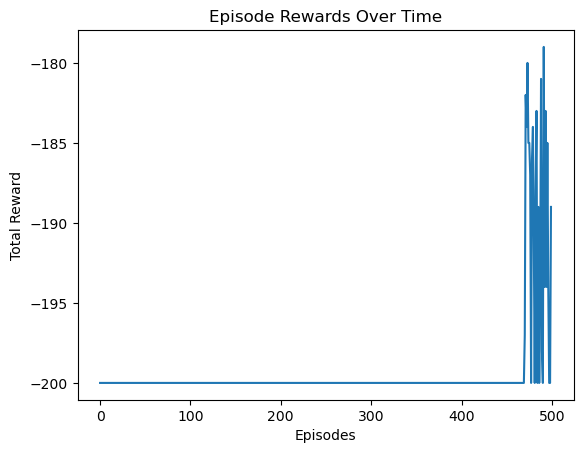

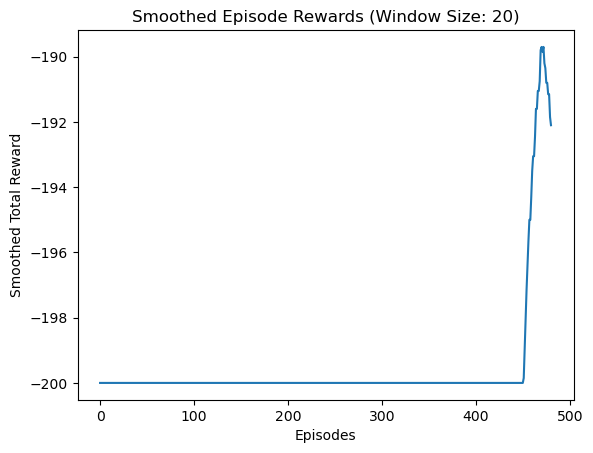

Starting training for attempt 2...


100%|██████████| 500/500 [00:11<00:00, 43.05it/s]


Training for attempt 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 149.46it/s]


Policy achieves an average total reward of -127.0 +/- 6.8 with confidence 95%.
Your policy passed the test!
Testing for attempt 2 completed!


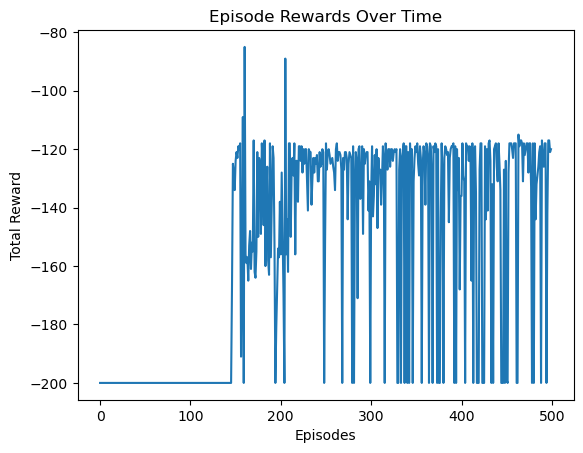

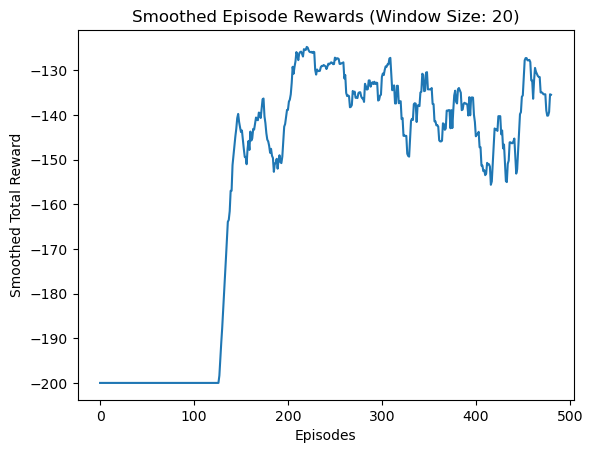

Starting training for attempt 3...


100%|██████████| 500/500 [00:10<00:00, 47.92it/s]


Training for attempt 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 144.74it/s]


Policy achieves an average total reward of -138.0 +/- 10.1 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for attempt 3 completed!


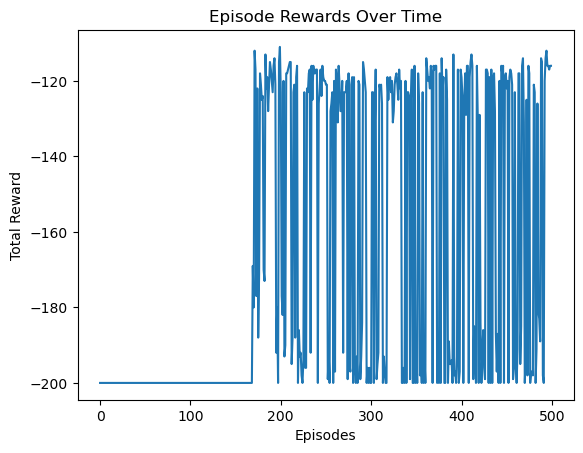

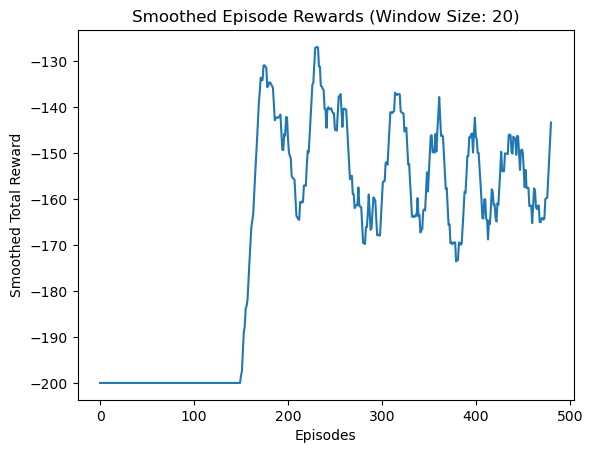

Starting training for attempt 4...


100%|██████████| 500/500 [00:09<00:00, 53.59it/s]


Training for attempt 4 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 143.25it/s]


Policy achieves an average total reward of -139.1 +/- 8.1 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for attempt 4 completed!


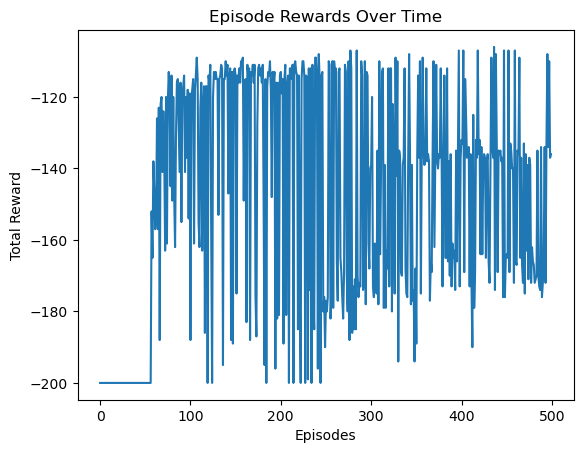

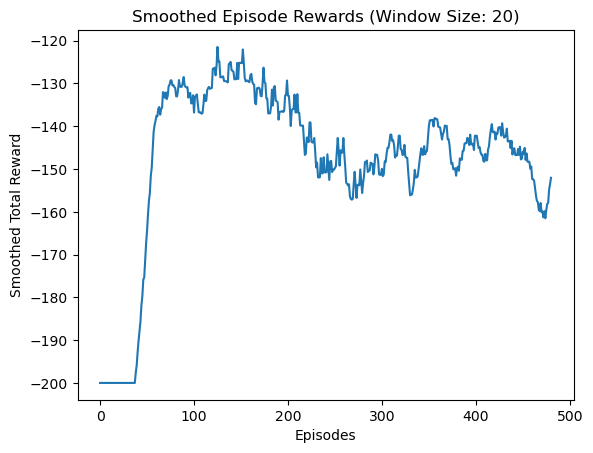

Starting training for attempt 5...


100%|██████████| 500/500 [00:08<00:00, 58.79it/s]


Training for attempt 5 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 144.15it/s]


Policy achieves an average total reward of -127.5 +/- 5.0 with confidence 95%.
Your policy passed the test!
Testing for attempt 5 completed!


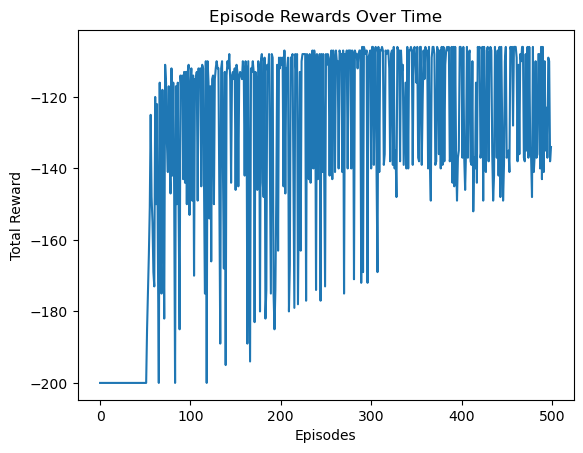

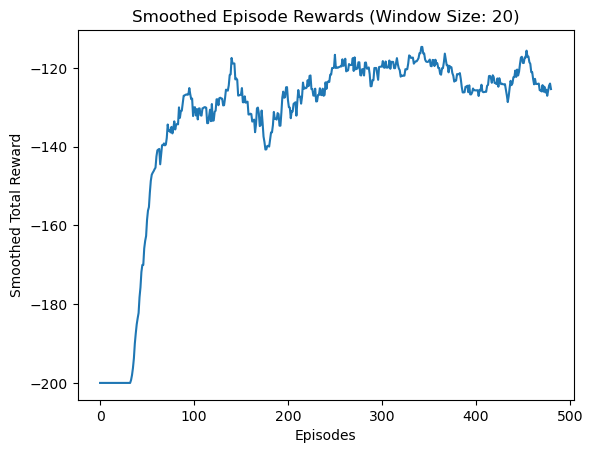

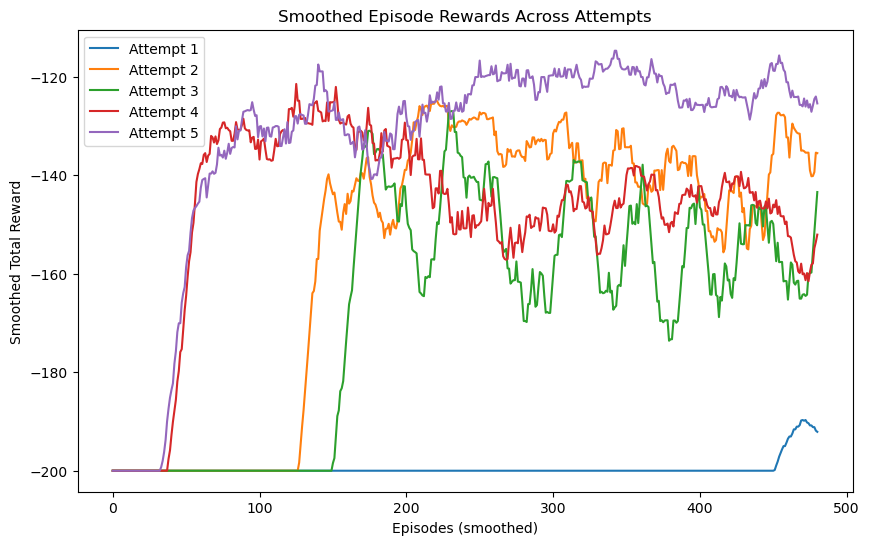

In [25]:
if __name__ == "__main__":

    predefined_coeffs = [
        predefined_coeff_matrix_1,
        predefined_coeff_matrix_2,
        predefined_coeff_matrix_2_1,
        predefined_coeff_matrix_3,
        predefined_coeff_matrix_4,
    ]  # If using predefined, provide the coefficient matrix

    all_rewards = []  # List to store raw rewards for each attempt

    for i, coefficients in enumerate(predefined_coeffs):
        # Initialize environment
        env = gym.make("MountainCar-v0")
        
        # Set hyperparameters for SARSA(λ)
        state_space = env.observation_space
        action_space = env.action_space
        alpha = 0.001  # Learning rate
        lamb = 0.6  # λ value for eligibility traces
        gamma = 1  # Discount factor
        epsilon = 0.1  # Exploration probability
        fourier_order = 2  # Fourier order
        max_non_zero_fourier = 2  # Max non-zero Fourier coefficients

        # Initialize SARSA(λ) agent
        agent = SarsaLambda(
            state_space=state_space,
            action_space=action_space,
            alpha=alpha,
            lamb=lamb,
            gamma=gamma,
            epsilon=epsilon,
            fourier_order=fourier_order,
            max_non_zero_fourier=max_non_zero_fourier,
            type_coeffs="predefined",
            defined_coeffs=coefficients,
        )

        # Initialize trainer
        trainer = Trainer(
            environment=env,
            agent=agent,
            epsilon=epsilon,
            number_episodes=500,  # Number of episodes to train
            episode_reward_trigger=-150,  # Reward threshold for early stopping
            early_stopping=True,  # Enable early stopping
        )

        # Train the agent
        print(f"Starting training for attempt {i + 1}...")
        trainer.train()
        print(f"Training for attempt {i + 1} completed!")
        trainer.test(N=50, verbose=True)
        print(f"Testing for attempt {i + 1} completed!")

        # Plot training results
        plt.plot(trainer.episode_reward_list)
        plt.title("Episode Rewards Over Time")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.show()

        plot_smoothed_rewards(trainer.episode_reward_list)  
        
        # Store raw rewards
        all_rewards.append(trainer.episode_reward_list)

        # Close environment
        env.close()

    # Plot smoothed rewards for all attempts
    plot_all_smoothed_rewards(all_rewards, window_size=20, labels=[f"Attempt {i+1}" for i in range(len(predefined_coeffs))])

In [ ]:
### c) hyperparameter optimization

In [26]:
from itertools import product
import numpy as np

def grid_search_hyperparameters(env, hyperparameters, n_trials=3, n_episodes=500, test_episodes=50):
    """
    Perform a grid search over the given hyperparameters.

    Args:
        env (gym.Env): The environment.
        hyperparameters (dict): Dictionary where keys are parameter names and values are lists of values to try.
        n_trials (int): Number of trials (train-test cycles) for each hyperparameter combination.
        n_episodes (int): Number of training episodes per trial.
        test_episodes (int): Number of test episodes per trial.
        
    Returns:
        results (list): List of dictionaries, each containing a combination of hyperparameters and its performance metrics.
    """
    # Generate all combinations of hyperparameters
    param_names = list(hyperparameters.keys())
    param_combinations = list(product(*hyperparameters.values()))
    
    results = []
    
    for params in param_combinations:
        # Create a dictionary for the current combination of parameters
        param_dict = dict(zip(param_names, params))
        print(f"Testing combination: {param_dict}")
        
        all_rewards = []
        
        for trial in range(n_trials):
            # Initialize the agent with the current hyperparameters
            agent = SarsaLambda(
                state_space=env.observation_space,
                action_space=env.action_space,
                alpha=param_dict.get("alpha", 0.001),
                lamb=param_dict.get("lamb", 0.9),
                gamma=param_dict.get("gamma", 0.99),
                epsilon=param_dict.get("epsilon", 0.3),
                fourier_order=param_dict.get("fourier_order", 2),
                max_non_zero_fourier=param_dict.get("max_non_zero_fourier", 2),
                type_coeffs="predefined",
                defined_coeffs=predefined_coeff_matrix_4
            )
            
            # Train the agent
            trainer = Trainer(environment=env, agent=agent, number_episodes=n_episodes)
            trainer.train()
            
            # Test the agent and record the average reward
            _, avg_reward, _ = trainer.test(N=test_episodes)
            all_rewards.append(avg_reward)
        
        # Compute statistics across trials
        avg_reward = np.mean(all_rewards)
        std_reward = np.std(all_rewards)
        
        # Store the results
        results.append({
            **param_dict,
            "avg_reward": avg_reward,
            "std_reward": std_reward
        })
        
    return results


In [28]:
# Define the environment
env = gym.make('MountainCar-v0')

# Define hyperparameters and their values to test
hyperparameter_grid = {
    "alpha": [0.0001, 0.001, 0.01],
    "lamb": [0.6, 0.9, 1],
    "epsilon": [0.1, 0.3]
}

# Perform grid search
grid_results = grid_search_hyperparameters(env, hyperparameter_grid, n_trials=3, n_episodes=500, test_episodes=50)

# Print results
for res in grid_results:
    print(f"Params: {res}, Avg Reward: {res['avg_reward']:.2f}, Std Dev: {res['std_reward']:.2f}")


Testing combination: {'alpha': 0.0001, 'lamb': 0.6, 'epsilon': 0.1}


100%|██████████| 500/500 [00:12<00:00, 39.96it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 40.40it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 40.63it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 102.19it/s]


Testing combination: {'alpha': 0.0001, 'lamb': 0.6, 'epsilon': 0.3}


100%|██████████| 500/500 [00:12<00:00, 41.36it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 41.26it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 41.13it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 106.22it/s]


Testing combination: {'alpha': 0.0001, 'lamb': 0.9, 'epsilon': 0.1}


100%|██████████| 500/500 [00:10<00:00, 47.08it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 47.24it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 46.38it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 135.15it/s]


Testing combination: {'alpha': 0.0001, 'lamb': 0.9, 'epsilon': 0.3}


100%|██████████| 500/500 [00:10<00:00, 48.19it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 47.96it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 47.45it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 155.29it/s]


Testing combination: {'alpha': 0.0001, 'lamb': 1, 'epsilon': 0.1}


100%|██████████| 500/500 [00:10<00:00, 46.22it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 45.72it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 38.93it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 102.46it/s]


Testing combination: {'alpha': 0.0001, 'lamb': 1, 'epsilon': 0.3}


100%|██████████| 500/500 [00:12<00:00, 40.45it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 49.11it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 47.79it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 154.93it/s]


Testing combination: {'alpha': 0.001, 'lamb': 0.6, 'epsilon': 0.1}


100%|██████████| 500/500 [00:08<00:00, 58.66it/s]


Checking solution...


100%|██████████| 500/500 [00:08<00:00, 56.56it/s]


Checking solution...


100%|██████████| 500/500 [00:08<00:00, 57.62it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 155.51it/s]


Testing combination: {'alpha': 0.001, 'lamb': 0.6, 'epsilon': 0.3}


100%|██████████| 500/500 [00:08<00:00, 57.30it/s]


Checking solution...


100%|██████████| 500/500 [00:08<00:00, 58.40it/s]


Checking solution...


100%|██████████| 500/500 [00:08<00:00, 57.09it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 150.05it/s]


Testing combination: {'alpha': 0.001, 'lamb': 0.9, 'epsilon': 0.1}


100%|██████████| 500/500 [00:08<00:00, 58.23it/s]


Checking solution...


100%|██████████| 500/500 [00:09<00:00, 55.50it/s]


Checking solution...


100%|██████████| 500/500 [00:09<00:00, 55.37it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 148.09it/s]


Testing combination: {'alpha': 0.001, 'lamb': 0.9, 'epsilon': 0.3}


100%|██████████| 500/500 [00:08<00:00, 56.48it/s]


Checking solution...


100%|██████████| 500/500 [00:08<00:00, 57.34it/s]


Checking solution...


100%|██████████| 500/500 [00:09<00:00, 54.83it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 146.70it/s]


Testing combination: {'alpha': 0.001, 'lamb': 1, 'epsilon': 0.1}


100%|██████████| 500/500 [00:12<00:00, 39.71it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 39.69it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 39.07it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 100.87it/s]


Testing combination: {'alpha': 0.001, 'lamb': 1, 'epsilon': 0.3}


100%|██████████| 500/500 [00:12<00:00, 39.99it/s]


Checking solution...


100%|██████████| 500/500 [00:13<00:00, 38.01it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 39.43it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 95.07it/s]


Testing combination: {'alpha': 0.01, 'lamb': 0.6, 'epsilon': 0.1}


100%|██████████| 500/500 [00:11<00:00, 44.83it/s]


Checking solution...


100%|██████████| 500/500 [00:11<00:00, 43.91it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 46.54it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 104.86it/s]


Testing combination: {'alpha': 0.01, 'lamb': 0.6, 'epsilon': 0.3}


100%|██████████| 500/500 [00:11<00:00, 44.06it/s]


Checking solution...


100%|██████████| 500/500 [00:11<00:00, 44.01it/s]


Checking solution...


100%|██████████| 500/500 [00:11<00:00, 43.38it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 101.23it/s]


Testing combination: {'alpha': 0.01, 'lamb': 0.9, 'epsilon': 0.1}


100%|██████████| 500/500 [00:12<00:00, 41.43it/s]


Checking solution...


100%|██████████| 500/500 [00:09<00:00, 53.75it/s]


Checking solution...


100%|██████████| 500/500 [00:09<00:00, 50.90it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 139.33it/s]


Testing combination: {'alpha': 0.01, 'lamb': 0.9, 'epsilon': 0.3}


100%|██████████| 500/500 [00:10<00:00, 46.98it/s]


Checking solution...


100%|██████████| 500/500 [00:10<00:00, 45.60it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 39.88it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 111.35it/s]


Testing combination: {'alpha': 0.01, 'lamb': 1, 'epsilon': 0.1}


100%|██████████| 500/500 [00:12<00:00, 39.59it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 40.24it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 39.97it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 102.61it/s]


Testing combination: {'alpha': 0.01, 'lamb': 1, 'epsilon': 0.3}


100%|██████████| 500/500 [00:12<00:00, 40.21it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 39.82it/s]


Checking solution...


100%|██████████| 500/500 [00:12<00:00, 39.87it/s]


Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 97.29it/s]

Params: {'alpha': 0.0001, 'lamb': 0.6, 'epsilon': 0.1, 'avg_reward': -177.75333333333333, 'std_reward': 21.905167325440715}, Avg Reward: -177.75, Std Dev: 21.91
Params: {'alpha': 0.0001, 'lamb': 0.6, 'epsilon': 0.3, 'avg_reward': -185.58666666666667, 'std_reward': 6.973326959844127}, Avg Reward: -185.59, Std Dev: 6.97
Params: {'alpha': 0.0001, 'lamb': 0.9, 'epsilon': 0.1, 'avg_reward': -156.9466666666667, 'std_reward': 14.946485279898495}, Avg Reward: -156.95, Std Dev: 14.95
Params: {'alpha': 0.0001, 'lamb': 0.9, 'epsilon': 0.3, 'avg_reward': -137.21333333333334, 'std_reward': 7.914043776028083}, Avg Reward: -137.21, Std Dev: 7.91
Params: {'alpha': 0.0001, 'lamb': 1, 'epsilon': 0.1, 'avg_reward': -153.39333333333332, 'std_reward': 32.96043014821797}, Avg Reward: -153.39, Std Dev: 32.96
Params: {'alpha': 0.0001, 'lamb': 1, 'epsilon': 0.3, 'avg_reward': -153.26, 'std_reward': 33.05022037243725}, Avg Reward: -153.26, Std Dev: 33.05
Params: {'alpha': 0.001, 'lamb': 0.6, 'epsilon': 0.1, 'av

Starting training for attempt 5...


100%|██████████| 500/500 [00:09<00:00, 53.15it/s]


Training for attempt 5 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 135.15it/s]


Policy achieves an average total reward of -142.5 +/- 8.5 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for attempt 5 completed!


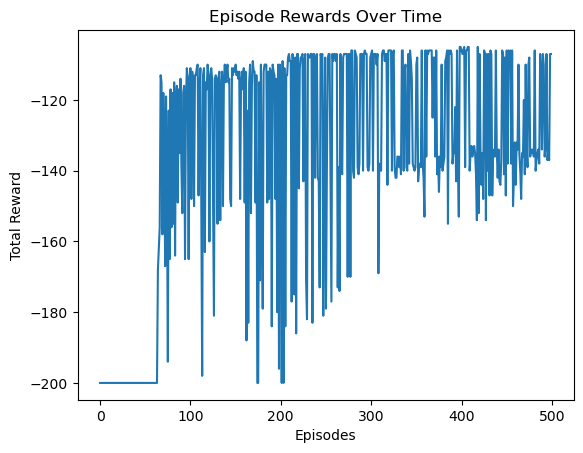

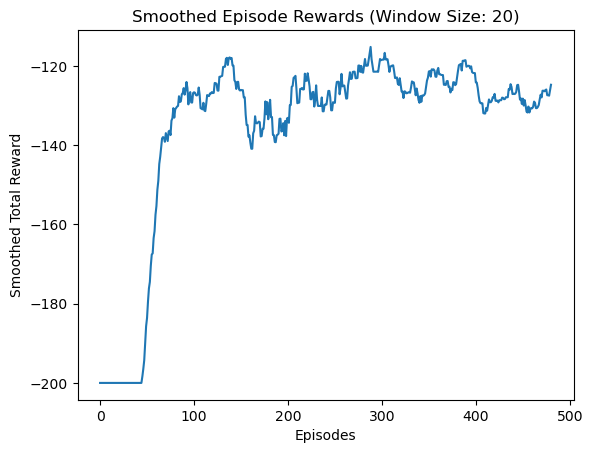

In [33]:
if __name__ == "__main__":

    
    all_rewards = []  # List to store raw rewards for each attempt

    
    # Initialize environment
    env = gym.make("MountainCar-v0")
    
    # Set hyperparameters for SARSA(λ)
    state_space = env.observation_space
    action_space = env.action_space
    alpha = 0.001  # Learning rate
    lamb = 0.6  # λ value for eligibility traces
    gamma = 1  # Discount factor
    epsilon = 0.1  # Exploration probability
    fourier_order = 2  # Fourier order
    max_non_zero_fourier = 2  # Max non-zero Fourier coefficients

    # Initialize SARSA(λ) agent
    agent = SarsaLambda(
        state_space=state_space,
        action_space=action_space,
        alpha=alpha,
        lamb=lamb,
        gamma=gamma,
        epsilon=epsilon,
        fourier_order=fourier_order,
        max_non_zero_fourier=max_non_zero_fourier,
        type_coeffs="predefined",
        defined_coeffs=predefined_coeff_matrix_4,
    )

    # Initialize trainer
    trainer = Trainer(
        environment=env,
        agent=agent,
        epsilon=epsilon,
        number_episodes=500,  # Number of episodes to train
        episode_reward_trigger=-150,  # Reward threshold for early stopping
        early_stopping=True,  # Enable early stopping
    )

    # Train the agent
    print(f"Starting training for attempt {i + 1}...")
    trainer.train()
    print(f"Training for attempt {i + 1} completed!")
    trainer.test(N=50, verbose=True)
    print(f"Testing for attempt {i + 1} completed!")

    # Plot training results
    plt.plot(trainer.episode_reward_list)
    plt.title("Episode Rewards Over Time")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.show()

    plot_smoothed_rewards(trainer.episode_reward_list)  
    
    # Store raw rewards
    all_rewards.append(trainer.episode_reward_list)

    # Close environment
    env.close()



Starting training for attempt 5...


100%|██████████| 500/500 [00:10<00:00, 49.12it/s]


Training for attempt 5 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 113.84it/s]


Policy achieves an average total reward of -129.3 +/- 6.1 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for attempt 5 completed!


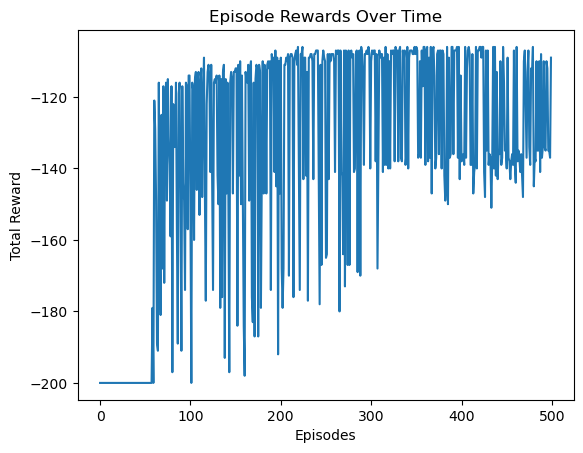

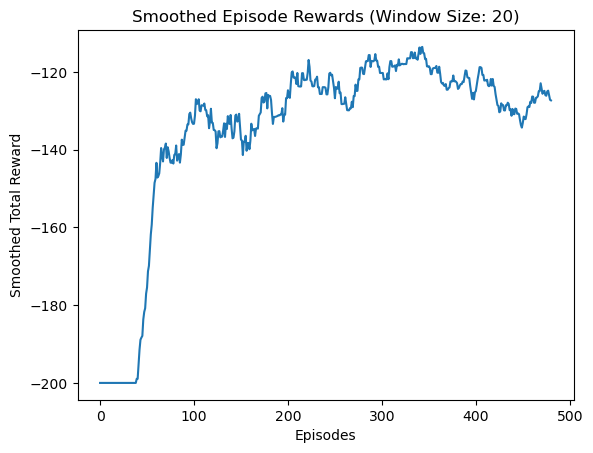

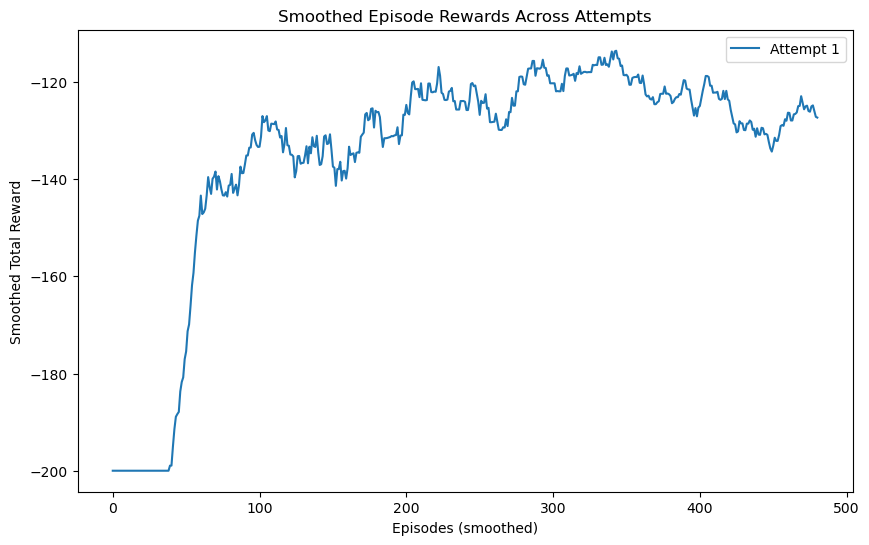

In [32]:
if __name__ == "__main__":

    
    all_rewards = []  # List to store raw rewards for each attempt

    
    # Initialize environment
    env = gym.make("MountainCar-v0")
    
    # Set hyperparameters for SARSA(λ)
    state_space = env.observation_space
    action_space = env.action_space
    alpha = 0.001  # Learning rate
    lamb = 0.6  # λ value for eligibility traces
    gamma = 1  # Discount factor
    epsilon = 0.3  # Exploration probability
    fourier_order = 2  # Fourier order
    max_non_zero_fourier = 2  # Max non-zero Fourier coefficients

    # Initialize SARSA(λ) agent
    agent = SarsaLambda(
        state_space=state_space,
        action_space=action_space,
        alpha=alpha,
        lamb=lamb,
        gamma=gamma,
        epsilon=epsilon,
        fourier_order=fourier_order,
        max_non_zero_fourier=max_non_zero_fourier,
        type_coeffs="predefined",
        defined_coeffs=predefined_coeff_matrix_4,
    )

    # Initialize trainer
    trainer = Trainer(
        environment=env,
        agent=agent,
        epsilon=epsilon,
        number_episodes=500,  # Number of episodes to train
        episode_reward_trigger=-150,  # Reward threshold for early stopping
        early_stopping=True,  # Enable early stopping
    )

    # Train the agent
    print(f"Starting training for attempt {i + 1}...")
    trainer.train()
    print(f"Training for attempt {i + 1} completed!")
    trainer.test(N=50, verbose=True)
    print(f"Testing for attempt {i + 1} completed!")

    # Plot training results
    plt.plot(trainer.episode_reward_list)
    plt.title("Episode Rewards Over Time")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.show()

    plot_smoothed_rewards(trainer.episode_reward_list)  
    
    # Store raw rewards
    all_rewards.append(trainer.episode_reward_list)

    # Close environment
    env.close()

    # Plot smoothed rewards for all attempts
    plot_all_smoothed_rewards(all_rewards, window_size=20, labels=[f"Attempt {i+1}" for i in range(len(predefined_coeffs))])

In [ ]:
## average reward as a function of alpha (learning rate)

In [94]:
def compute_smoothed_rewards(rewards, window_size=20):
    """Compute smoothed rewards using a moving average."""
    smoothed = np.convolve(rewards, np.ones(window_size) / window_size, mode="valid")
    std_devs = [
        np.std(rewards[max(0, i - window_size + 1):i + 1])
        for i in range(len(smoothed))
    ]
    return smoothed, np.array(std_devs)

def plot_smoothed_rewards_with_confidence(rewards, cf,window_size=20, label=None):
    """Plot smoothed rewards with confidence intervals."""

    
    smoothed_rewards, std_devs = compute_smoothed_rewards(rewards, window_size)
    x_vals = np.arange(len(smoothed_rewards))
    plt.plot(x_vals, smoothed_rewards, label=label)
    if cf:
        plt.fill_between(
            x_vals,
            smoothed_rewards - std_devs,
            smoothed_rewards + std_devs,
            alpha=0.3
        )
        plt.title("Smoothed Rewards with Confidence Interval")
    else:
        plt.title("Smoothed Rewards")
    plt.xlabel("Episodes")
    plt.ylabel("Smoothed Reward")
    
    if label:
        plt.legend()

def plot_all_smoothed_rewards(all_rewards, window_size=20, labels=None, cf = True):
    """Plot smoothed rewards with confidence intervals for all attempts."""
    plt.figure(figsize=(12, 6)) 
    for i, rewards in enumerate(all_rewards):
        label = labels[i] if labels else None
        plot_smoothed_rewards_with_confidence(rewards,cf, window_size, label)
    plt.show()

Starting training for attempt 1...


100%|██████████| 500/500 [00:13<00:00, 36.62it/s]


Training for attempt 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 89.49it/s]


Policy achieves an average total reward of -183.6 +/- 2.8 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for attempt 1 completed!
Starting training for attempt 2...


100%|██████████| 500/500 [00:09<00:00, 51.20it/s]


Training for attempt 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 155.76it/s]


Policy achieves an average total reward of -130.5 +/- 5.3 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for attempt 2 completed!
Starting training for attempt 3...


100%|██████████| 500/500 [00:12<00:00, 38.80it/s]


Training for attempt 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 97.67it/s]


Policy achieves an average total reward of -197.7 +/- 0.8 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for attempt 3 completed!
Starting training for attempt 4...


100%|██████████| 500/500 [00:15<00:00, 32.86it/s]


Training for attempt 4 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 89.43it/s]


Policy achieves an average total reward of -200.0 +/- 0.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for attempt 4 completed!


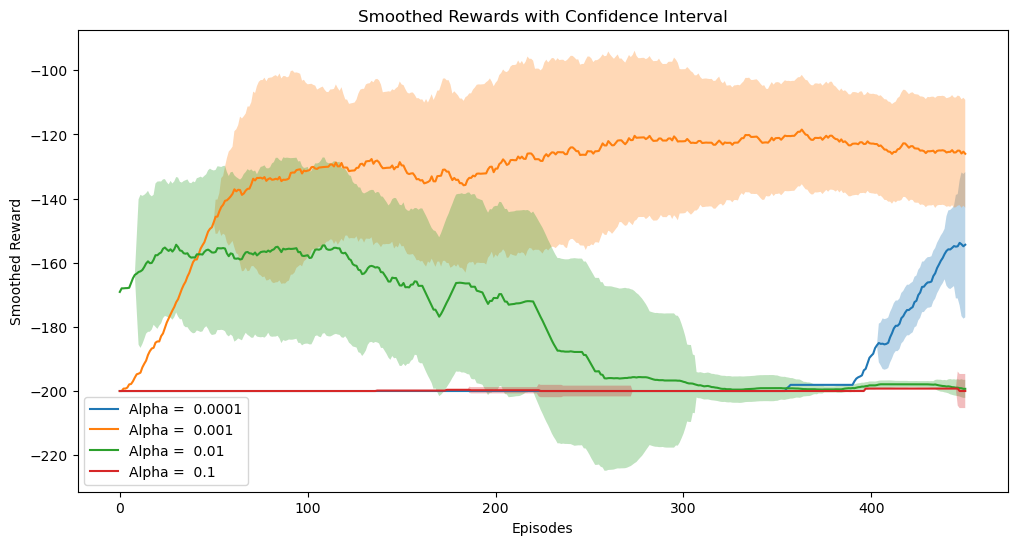

In [58]:
if __name__ == "__main__":

    alpha_list = [0.0001, 0.001, 0.01, 0.1]

    all_rewards = []  # List to store raw rewards for each attempt

    for i, alpha_v in enumerate(alpha_list):
        # Initialize environment
        env = gym.make("MountainCar-v0")
        
        # Set hyperparameters for SARSA(λ)
        state_space = env.observation_space
        action_space = env.action_space
        lamb = 0.6  # λ value for eligibility traces
        gamma = 1  # Discount factor
        epsilon = 0.3  # Exploration probability
        fourier_order = 2  # Fourier order
        max_non_zero_fourier = 2  # Max non-zero Fourier coefficients

        # Initialize SARSA(λ) agent
        agent = SarsaLambda(
            state_space=state_space,
            action_space=action_space,
            alpha=alpha_v,
            lamb=lamb,
            gamma=gamma,
            epsilon=epsilon,
            fourier_order=fourier_order,
            max_non_zero_fourier=max_non_zero_fourier,
            type_coeffs="predefined",
            defined_coeffs=predefined_coeff_matrix_4,
        )

        # Initialize trainer
        trainer = Trainer(
            environment=env,
            agent=agent,
            epsilon=epsilon,
            number_episodes=500,  # Number of episodes to train
            episode_reward_trigger=-150,  # Reward threshold for early stopping
            early_stopping=True,  # Enable early stopping
        )

        # Train the agent
        print(f"Starting training for attempt {i + 1}...")
        trainer.train()
        print(f"Training for attempt {i + 1} completed!")
        trainer.test(N=50, verbose=True)
        print(f"Testing for attempt {i + 1} completed!")

        # Plot training results
        # plt.plot(trainer.episode_reward_list)
        # plt.title("Episode Rewards Over Time")
        # plt.xlabel("Episodes")
        # plt.ylabel("Total Reward")
        # plt.show()

        # plot_smoothed_rewards(trainer.episode_reward_list)  
        
        # Store raw rewards
        all_rewards.append(trainer.episode_reward_list)

        # Close environment
        env.close()

    # Plot smoothed rewards for all attempts
    plot_all_smoothed_rewards(all_rewards, window_size=50, labels=[f"Alpha =  {alpha}" for alpha in alpha_list])

In [59]:
### decaying learning rate

Starting training for attempt 1...


100%|██████████| 500/500 [00:07<00:00, 70.77it/s]


Training for attempt 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 158.58it/s]


Policy achieves an average total reward of -127.4 +/- 5.2 with confidence 95%.
Your policy passed the test!
Testing for attempt 1 completed!
Starting training for attempt 2...


100%|██████████| 500/500 [00:07<00:00, 70.81it/s]


Training for attempt 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 150.70it/s]


Policy achieves an average total reward of -130.1 +/- 6.1 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for attempt 2 completed!
Starting training for attempt 3...


100%|██████████| 500/500 [00:06<00:00, 72.28it/s]


Training for attempt 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 144.42it/s]


Policy achieves an average total reward of -123.5 +/- 7.0 with confidence 95%.
Your policy passed the test!
Testing for attempt 3 completed!
Starting training for attempt 4...


100%|██████████| 500/500 [00:07<00:00, 71.17it/s]


Training for attempt 4 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 161.44it/s]


Policy achieves an average total reward of -120.6 +/- 4.2 with confidence 95%.
Your policy passed the test!
Testing for attempt 4 completed!
Starting training for attempt 5...


100%|██████████| 500/500 [00:07<00:00, 67.49it/s]


Training for attempt 5 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 144.52it/s]


Policy achieves an average total reward of -132.7 +/- 5.9 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for attempt 5 completed!
Starting training for attempt 6...


100%|██████████| 500/500 [00:07<00:00, 68.72it/s]


Training for attempt 6 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 151.92it/s]


Policy achieves an average total reward of -130.9 +/- 6.0 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for attempt 6 completed!


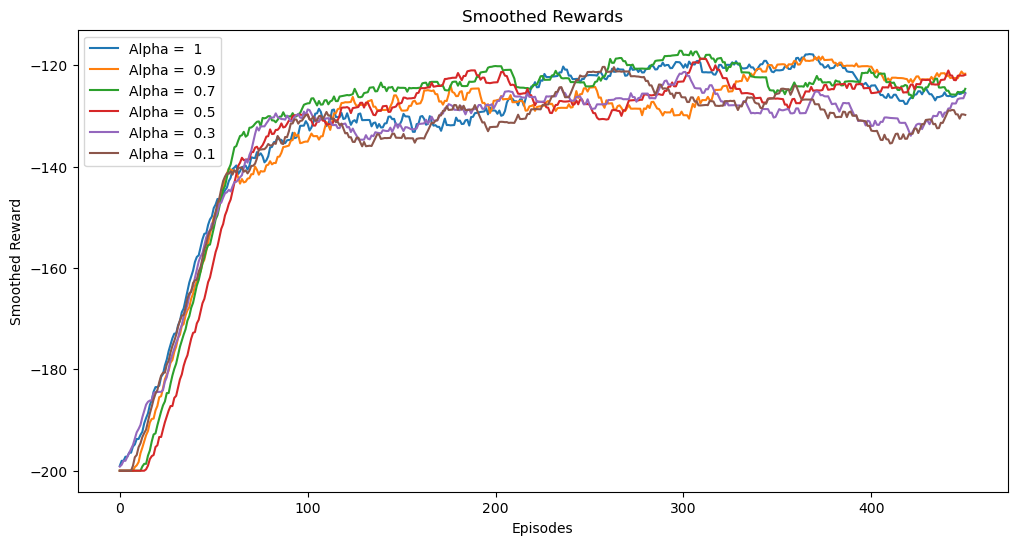

In [98]:
if __name__ == "__main__":

    reduction_factor = [1, 0.9, 0.7, 0.5, 0.3, 0.1]

    all_rewards = []  # List to store raw rewards for each attempt

    for i, red in enumerate(reduction_factor):
        # Initialize environment
        env = gym.make("MountainCar-v0")
        
        # Set hyperparameters for SARSA(λ)
        state_space = env.observation_space
        action_space = env.action_space
        lamb = 0.6  # λ value for eligibility traces
        alpha = 0.001
        gamma = 1  # Discount factor
        epsilon = 0.3  # Exploration probability
        fourier_order = 2  # Fourier order
        max_non_zero_fourier = 2  # Max non-zero Fourier coefficients

        # Initialize SARSA(λ) agent
        agent = SarsaLambda(
            state_space=state_space,
            action_space=action_space,
            alpha=alpha,
            reduction_factor=red,
            lamb=lamb,
            gamma=gamma,
            epsilon=epsilon,
            fourier_order=fourier_order,
            max_non_zero_fourier=max_non_zero_fourier,
            type_coeffs="predefined",
            defined_coeffs=predefined_coeff_matrix_4,
        )

        # Initialize trainer
        trainer = Trainer(
            environment=env,
            agent=agent,
            epsilon=epsilon,
            number_episodes=500,  # Number of episodes to train
            episode_reward_trigger=-150,  # Reward threshold for early stopping
            early_stopping=True,  # Enable early stopping
        )

        # Train the agent
        print(f"Starting training for attempt {i + 1}...")
        trainer.train()
        print(f"Training for attempt {i + 1} completed!")
        trainer.test(N=50, verbose=True)
        print(f"Testing for attempt {i + 1} completed!")

        # Plot training results
        # plt.plot(trainer.episode_reward_list)
        # plt.title("Episode Rewards Over Time")
        # plt.xlabel("Episodes")
        # plt.ylabel("Total Reward")
        # plt.show()

        #plot_smoothed_rewards(trainer.episode_reward_list)  
        
        # Store raw rewards
        all_rewards.append(trainer.episode_reward_list)

        # Close environment
        env.close()

    # Plot smoothed rewards for all attempts
    plot_all_smoothed_rewards(all_rewards, window_size=50, labels=[f"Alpha =  {red}" for red in reduction_factor], cf = False)

In [ ]:
### e) hyperparameter = lambda

Starting training for attempt 1...


100%|██████████| 500/500 [00:07<00:00, 67.70it/s]


Training for attempt 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 154.87it/s]


Policy achieves an average total reward of -133.4 +/- 1.2 with confidence 95%.
Your policy passed the test!
Testing for attempt 1 completed!
Starting training for attempt 2...


100%|██████████| 500/500 [00:07<00:00, 71.16it/s]


Training for attempt 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 139.84it/s]


Policy achieves an average total reward of -118.9 +/- 5.3 with confidence 95%.
Your policy passed the test!
Testing for attempt 2 completed!
Starting training for attempt 3...


100%|██████████| 500/500 [00:07<00:00, 64.15it/s]


Training for attempt 3 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 167.21it/s]


Policy achieves an average total reward of -118.9 +/- 4.0 with confidence 95%.
Your policy passed the test!
Testing for attempt 3 completed!
Starting training for attempt 4...


100%|██████████| 500/500 [00:08<00:00, 62.17it/s]


Training for attempt 4 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 162.66it/s]


Policy achieves an average total reward of -126.1 +/- 3.6 with confidence 95%.
Your policy passed the test!
Testing for attempt 4 completed!


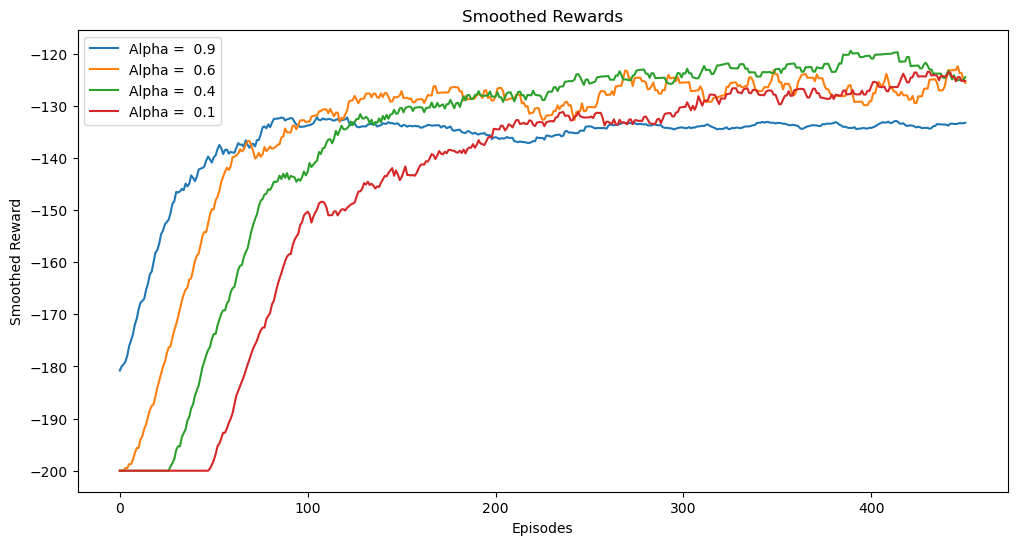

In [104]:
if __name__ == "__main__":

    lambda_values = [0.9, 0.6,  0.4, 0.1]

    all_rewards = []  # List to store raw rewards for each attempt

    for i, lamb in enumerate(lambda_values):
        # Initialize environment
        env = gym.make("MountainCar-v0")
        
        # Set hyperparameters for SARSA(λ)
        state_space = env.observation_space
        action_space = env.action_space
        alpha = 0.001
        gamma = 1  # Discount factor
        epsilon = 0.3  # Exploration probability
        fourier_order = 2  # Fourier order
        max_non_zero_fourier = 2  # Max non-zero Fourier coefficients
        reduction_factor = 0.7

        # Initialize SARSA(λ) agent
        agent = SarsaLambda(
            state_space=state_space,
            action_space=action_space,
            alpha=alpha,
            reduction_factor=reduction_factor,
            lamb=lamb,
            gamma=gamma,
            epsilon=epsilon,
            fourier_order=fourier_order,
            max_non_zero_fourier=max_non_zero_fourier,
            type_coeffs="predefined",
            defined_coeffs=predefined_coeff_matrix_4,
        )

        # Initialize trainer
        trainer = Trainer(
            environment=env,
            agent=agent,
            epsilon=epsilon,
            number_episodes=500,  # Number of episodes to train
            episode_reward_trigger=-150,  # Reward threshold for early stopping
            early_stopping=True,  # Enable early stopping
        )

        # Train the agent
        print(f"Starting training for attempt {i + 1}...")
        trainer.train()
        print(f"Training for attempt {i + 1} completed!")
        trainer.test(N=50, verbose=True)
        print(f"Testing for attempt {i + 1} completed!")

        # Plot training results
        # plt.plot(trainer.episode_reward_list)
        # plt.title("Episode Rewards Over Time")
        # plt.xlabel("Episodes")
        # plt.ylabel("Total Reward")
        # plt.show()

        #plot_smoothed_rewards(trainer.episode_reward_list)  
        
        # Store raw rewards
        all_rewards.append(trainer.episode_reward_list)

        # Close environment
        env.close()

    # Plot smoothed rewards for all attempts
    plot_all_smoothed_rewards(all_rewards, window_size=50, labels=[f"Alpha =  {lamb}" for lamb in lambda_values], cf = False)

In [103]:
### Q initialization

In [107]:
if __name__ == "__main__":

    initializations = ["zeros", "random uniform", "random gaussian"]

    all_rewards = []  # List to store raw rewards for each attempt

    for i, type_initialization in enumerate(initializations):
        # Initialize environment
        env = gym.make("MountainCar-v0")
        
        # Set hyperparameters for SARSA(λ)
        state_space = env.observation_space
        action_space = env.action_space
        alpha = 0.001
        gamma = 1  # Discount factor
        epsilon = 0.3  # Exploration probability
        fourier_order = 2  # Fourier order
        max_non_zero_fourier = 2  # Max non-zero Fourier coefficients
        reduction_factor = 0.7

        # Initialize SARSA(λ) agent
        agent = SarsaLambda(
            state_space=state_space,
            action_space=action_space,
            alpha=alpha,
            reduction_factor=reduction_factor,
            lamb=lamb,
            gamma=gamma,
            epsilon=epsilon,
            fourier_order=fourier_order,
            max_non_zero_fourier=max_non_zero_fourier,
            type_coeffs="predefined",
            defined_coeffs=predefined_coeff_matrix_4,
            initialization= type_initialization
        )

        # Initialize trainer
        trainer = Trainer(
            environment=env,
            agent=agent,
            epsilon=epsilon,
            number_episodes=500,  # Number of episodes to train
            episode_reward_trigger=-150,  # Reward threshold for early stopping
            early_stopping=True,  # Enable early stopping
        )

        # Train the agent
        print(f"Starting training for attempt {i + 1}...")
        trainer.train()
        print(f"Training for attempt {i + 1} completed!")
        trainer.test(N=50, verbose=True)
        print(f"Testing for attempt {i + 1} completed!")

        # Plot training results
        # plt.plot(trainer.episode_reward_list)
        # plt.title("Episode Rewards Over Time")
        # plt.xlabel("Episodes")
        # plt.ylabel("Total Reward")
        # plt.show()

        #plot_smoothed_rewards(trainer.episode_reward_list)  
        
        # Store raw rewards
        all_rewards.append(trainer.episode_reward_list)

        # Close environment
        env.close()

    # Plot smoothed rewards for all attempts
    plot_all_smoothed_rewards(all_rewards, window_size=50, labels=[f"Alpha =  {lamb}" for lamb in lambda_values], cf = False)

Starting training for attempt 1...


100%|██████████| 500/500 [00:07<00:00, 65.45it/s]


Training for attempt 1 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 160.43it/s]


Policy achieves an average total reward of -123.8 +/- 4.0 with confidence 95%.
Your policy passed the test!
Testing for attempt 1 completed!
Starting training for attempt 2...


100%|██████████| 500/500 [00:10<00:00, 49.46it/s]


Training for attempt 2 completed!
Checking solution...


Episode: 100%|██████████| 50/50 [00:00<00:00, 113.26it/s]

Policy achieves an average total reward of -177.2 +/- 6.8 with confidence 95%.
Your policy did not pass the test! The average reward of your policy needs to be greater than -135 with 95% confidence
Testing for attempt 2 completed!


TypeError: __init__() should return None, not 'dict'